In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv("/content/drive/MyDrive/LG Aimers/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/LG Aimers/test.csv")

print("train 데이터: ",train_data.shape)
print("test 데이터: ",test_data.shape)

train 데이터:  (40506, 464)
test 데이터:  (17361, 465)


In [ ]:
#전부 null인 칼럼 제거
cols = train_data.columns
null_list = []

for i in cols:
    if train_data[i].isna().sum() == train_data.shape[0]:
        null_list.append(i)

train_not_null = train_data.drop(columns=null_list)
print("전부 null인 칼럼 제거 후 ",train_not_null.shape)

전부 null인 칼럼 제거 후  (40506, 186)


대회 정정사항 null인 칼럼 제거 후  (40506, 178)


In [ ]:
# # 이전 코드의 각 COORDINATE_columns , POSITION_columns 의 개수
# COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]
# POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]

# print(len(COORDINATE_columns))
# print(len(POSITION_columns))

In [ ]:
train_not_null.columns

Index(['Wip Line_Dam', 'Process Desc._Dam', 'Equipment_Dam',
       'Model.Suffix_Dam', 'Workorder_Dam', 'Insp. Seq No._Dam',
       'Insp Judge Code_Dam', 'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Θ Collect Result_Dam',
       ...
       'Head Clean Position Z Collect Result_Fill2',
       'Head Purge Position X Collect Result_Fill2',
       'Head Purge Position Y Collect Result_Fill2',
       'Head Purge Position Z Collect Result_Fill2',
       'Machine Tact time Collect Result_Fill2',
       'PalletID Collect Result_Fill2', 'Production Qty Collect Result_Fill2',
       'Receip No Collect Result_Fill2', 'WorkMode Collect Result_Fill2',
       'target'],
      dtype='object', length=178)

In [ ]:
train_not_null.head()

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal


In [ ]:
COORDINATE_column_nnull = [col for col in train_not_null.columns if 'coordinate' in col.lower()]
POSITION_columns_nnull = [col for col in train_not_null.columns if 'position' in col.lower()]

print(len(COORDINATE_column_nnull))
print(len(POSITION_columns_nnull))

24
48


In [ ]:
train_position=train_not_null[COORDINATE_column_nnull]
# 기준 거리 설정
threshold = 40
# 원본 데이터프레임의 모든 칼럼에 대해 반복
for col in train_position.columns:
    print(f"Processing column: {col}")

    # value_counts로부터 데이터프레임 생성
    value_counts = train_position[col].value_counts()
    df = value_counts.reset_index()
    df.columns = ['value', 'count']

    # 거리 계산
    distances = calculate_distances(df, threshold)

    # 원본 데이터에 거리 값을 적용
    def apply_distances(value):
        if value in distances['value'].values:
            return distances.loc[distances['value'] == value, 'distance'].values[0]
        else:
            return np.nan

   # 새 데이터프레임 생성
    train_position_copy = train_position.copy()
    # 거리 값을 적용할 새로운 칼럼 생성
    train_position_copy[col + '_distance'] = train_position_copy[col].apply(apply_distances)

    # 원본 데이터프레임에 새로운 칼럼 추가
    # .loc 사용하여 칼럼을 추가합니다.
    train_position.loc[:, col + '_distance'] = train_position_copy[col + '_distance']

# 결과 출력
print(train_position.head())


In [29]:
pd.DataFrame(data)

,count,frequency
0,377.1,10918
1,377.5,8560
2,1383.9,7125
3,377.3,4524
4,1270.7,3621
5,1269.0,1779
6,1271.3,1056
7,383.1,1028
8,1271.8,745
9,1393.5,535


In [55]:
train_coordinate= train_not_null[COORDINATE_column_nnull]

In [89]:
train_position['CURE END POSITION Z Collect Result_Fill2'].value_counts()

,count
CURE END POSITION Z Collect Result_Fill2,
33,33113
32,7297
22,96


In [83]:
train_position.columns

Index(['CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Θ Collect Result_Dam',
       'CURE STANDBY POSITION X Collect Result_Dam',
       'CURE STANDBY POSITION Z Collect Result_Dam',
       'CURE STANDBY POSITION Θ Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'CURE START POSITION Z Collect Result_Dam',
       'CURE START POSITION Θ Collect Result_Dam',
       'HEAD Standby Position X Collect Result_Dam',
       'HEAD Standby Position Y Collect Result_Dam',
       'HEAD Standby Position Z Collect Result_Dam',
       'Head Clean Position X Collect Result_Dam',
       'Head Clean Position Y Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position X Collect Result_Dam',
       'Head Purge Position Y Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position X Collect Result_Dam',
       'Head Zero Position

In [92]:
train_position['Head Purge Position Z Collect Result_Fill1'].value_counts()

,count
Head Purge Position Z Collect Result_Fill1,
50,24059
85,8301
145,8146


In [94]:

train_position['Head Clean Position Y Collect Result_Dam'].value_counts()

,count
Head Clean Position Y Collect Result_Dam,
127.5,24059
66.0,16447


In [96]:
train_position['Head Clean Position Y Collect Result_Fill2'].value_counts()

,count
Head Clean Position Y Collect Result_Fill2,
119,24059
50,16447


In [97]:
train_position['Head Clean Position Y Collect Result_Fill1'].value_counts()

,count
Head Clean Position Y Collect Result_Fill1,
123.4,24059
50.0,16447


In [ ]:
train_position['Head Clean Position Y Collect Result_Dam'].value_counts()

In [91]:
train_position['Head Purge Position X Collect Result_Dam'].value_counts()

,count
Head Purge Position X Collect Result_Dam,
257.00,16447
130.85,15533
124.00,8493
118.85,33


In [82]:
train_position['Head Zero Position Z Collect Result_Dam'].value_counts()

,count
Head Zero Position Z Collect Result_Dam,
300.0,23995
265.0,16447
303.5,64


In [81]:
train_position['Head Purge Position Z Collect Result_Dam'].value_counts()

,count
Head Purge Position Z Collect Result_Dam,
66.00,24059
133.50,8246
130.85,7870
124.50,331


In [79]:
train_position['Head Clean Position Z Collect Result_Dam'].value_counts()

,count
Head Clean Position Z Collect Result_Dam,
66.00,24059
133.50,8231
130.85,7885
124.50,331


In [76]:
train_position['Head Zero Position Z Collect Result_Dam'].value_counts()

,count
Head Zero Position Z Collect Result_Dam,
300.0,23995
265.0,16447
303.5,64


In [ ]:
Head Clean Position X Collect Result_Dam'
Head Zero Position X Collect Result_Dam'

In [69]:
POSITION_columns_nnull

['CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE STANDBY POSITION X Collect Result_Dam',
 'CURE STANDBY POSITION Z Collect Result_Dam',
 'CURE STANDBY POSITION Θ Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Z Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'HEAD Standby Position X Collect Result_Dam',
 'HEAD Standby Position Y Collect Result_Dam',
 'HEAD Standby Position Z Collect Result_Dam',
 'Head Clean Position X Collect Result_Dam',
 'Head Clean Position Y Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Head Purge Position X Collect Result_Dam',
 'Head Purge Position Y Collect Result_Dam',
 'Head Purge Position Z Collect Result_Dam',
 'Head Zero Position X Collect Result_Dam',
 'Head Zero Position Y Collect Result_Dam',
 'Head Zero Position Z Collect Result_Dam',
 'HEAD Standby Position X Collect Result_Fill1',
 'H

In [68]:
train_position = train_not_null[POSITION_columns_nnull]
train_position

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,...,CURE START POSITION Θ Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,HEAD Standby Position Y Collect Result_Fill2,HEAD Standby Position Z Collect Result_Fill2,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2
0,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90,274.51,...,90,243.7,270,50,-10,119,50.0,91.8,270,50
1,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90,257.00,...,90,270.0,50,-10,119,50,91.8,270.0,50,85
2,1000.0,12.5,90,1150,33.5,0,280,33.5,90,274.33,...,90,243.5,270,50,-10,119,50.0,91.8,270,50
3,1000.0,12.5,90,1150,33.5,0,280,33.5,90,257.00,...,90,270.0,50,-10,119,50,91.8,270.0,50,85
4,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90,257.00,...,90,270.0,50,-10,119,50,91.8,270.0,50,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90,257.00,...,90,270.0,50,-10,119,50,91.8,270.0,50,85
40502,1000.0,12.5,90,1150,33.5,0,280,33.5,90,274.33,...,90,243.5,270,50,-10,119,50.0,91.8,270,50
40503,240.0,2.5,-90,1150,33.5,0,1030,33.5,-90,274.78,...,90,243.7,270,50,-10,119,50.0,91.8,270,50
40504,1000.0,12.5,90,1150,33.5,0,280,33.5,90,257.00,...,90,270.0,50,-10,119,50,91.8,270.0,50,85


In [ ]:
data =

In [60]:
# 파라미터 설정
threshold = 10

# 거리 계산 및 처리 함수 정의
def calculate_distances(df, threshold):
    # 거리 계산을 위한 빈 데이터프레임 생성
    distances = pd.DataFrame(index=df.index)
    distances['value'] = df['value']  # 기존 값 복사
    distances['distance'] = np.nan  # 거리 칼럼 초기화

    # 빈도수가 높은 값들을 기준으로 처리
    while not df.empty:
        # 가장 빈도수가 높은 값과 그 빈도수 선택
        most_frequent_value = df['value'].iloc[0]

        # 해당 기준값으로부터 threshold 범위 이내의 값을 처리
        df_within_threshold = df[abs(df['value'] - most_frequent_value) <= threshold]
        df_outside_threshold = df[abs(df['value'] - most_frequent_value) > threshold]

        # 기준 값과의 거리 계산
        distances.loc[df_within_threshold.index, 'distance'] = df_within_threshold['value'].apply(lambda x: abs(x - most_frequent_value))

        # 최빈값은 거리가 0이 되도록
        distances.loc[df_within_threshold.index[df_within_threshold['value'] == most_frequent_value], 'distance'] = 0
        # 범위 이내의 값 처리 후 제거
        df = df_outside_threshold

    return distances

value_counts = train_not_null['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'].value_counts()
df = value_counts.reset_index()
df.columns = ['value', 'count']

# 거리 계산
distances = calculate_distances(df, threshold)

# 결과 출력
print(distances)

     value  distance
0   463.00      0.00
1   162.40      0.00
2   162.70      0.30
3   463.50      0.50
4   164.20      1.80
5   550.40      0.00
6   463.80      0.80
7   550.30      0.10
8   550.60      0.20
9   465.10      2.10
10  551.50      1.10
11  462.50      0.50
12  465.30      2.30
13  551.70      1.30
14  548.90      1.50
15  161.20      1.20
16  550.50      0.10
17  465.50      2.50
18  163.50      1.10
19  164.10      1.70
20  551.80      1.40
21  161.70      0.70
22  552.10      1.70
23  552.00      1.60
24  549.40      1.00
25  462.75      0.25
26  164.50      2.10
27  163.30      0.90
28  164.00      1.60
29  163.80      1.40
30  551.30      0.90
31  551.20      0.80
32  163.40      1.00
33  550.70      0.30
34  462.20      0.80
35  163.70      1.30
36  163.00      0.60
37  551.60      1.20
38  163.60      1.20
39  163.10      0.70
40  551.00      0.60


In [59]:
# 거리 계산 함수 정의
def calculate_distances(df, threshold):
    # 거리 계산을 위한 빈 데이터프레임 생성
    distances = pd.DataFrame(index=df.index)
    distances['value'] = df['value']  # 기존 값 복사
    distances['distance'] = np.nan  # 거리 칼럼 초기화

    # 빈도수가 높은 값들을 기준으로 처리
    while not df.empty:
        # 가장 빈도수가 높은 값과 그 빈도수 선택
        most_frequent_value = df['value'].iloc[0]

        # 해당 기준값으로부터 threshold 범위 이내의 값을 처리
        df_within_threshold = df[abs(df['value'] - most_frequent_value) <= threshold]
        df_outside_threshold = df[abs(df['value'] - most_frequent_value) > threshold]

        # 기준 값과의 거리 계산
        distances.loc[df_within_threshold.index, 'distance'] = df_within_threshold['value'].apply(lambda x: abs(x - most_frequent_value))

        # 최빈값은 거리가 0이 되도록
        distances.loc[df_within_threshold.index[df_within_threshold['value'] == most_frequent_value], 'distance'] = 0
        # 범위 이내의 값 처리 후 제거
        df = df_outside_threshold

    return distances

In [62]:
train_coordinate =train_not_null[COORDINATE_column_nnull]
# 기준 거리 설정
threshold = 10

# 원본 데이터프레임의 모든 칼럼에 대해 반복
for col in train_coordinate.columns:
    print(f"Processing column: {col}")

    # value_counts로부터 데이터프레임 생성
    value_counts = train_coordinate[col].value_counts()
    df = value_counts.reset_index()
    df.columns = ['value', 'count']

    # 거리 계산
    distances = calculate_distances(df, threshold)

    # 원본 데이터에 거리 값을 적용
    def apply_distances(value):
        if value in distances['value'].values:
            return distances.loc[distances['value'] == value, 'distance'].values[0]
        else:
            return np.nan

    # 데이터프레임 복사본 생성
    train_coordinate_copy = train_coordinate.copy()
    # 거리 값을 적용할 새로운 칼럼 생성
    train_coordinate_copy[col + '_distance'] = train_coordinate_copy[col].apply(apply_distances)

    # 원본 데이터프레임에 새로운 칼럼 추가
    train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']

# 결과 출력
print(train_coordinate.head())


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2


<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


Processing column: HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2
   HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam  \
0                                              550.5          
1                                              463.8          
2                                              162.4          
3                                              465.5          
4                                              462.5          

   HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam  \
0                                              464.3          
1                                              160.8          
2                                              465.4          
3                                              552.0          
4                                              159.5          

   HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam  \
0                                              161.4          
1                                     

<ipython-input-62-5e0ed03c7e9e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coordinate[col + '_distance'] = train_coordinate_copy[col + '_distance']


In [63]:
train_coordinate

,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,...,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1_distance,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1_distance,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2_distance,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2_distance
0,550.5,464.3,161.4,384.0,383.1,384.00,274.51,274.51,838.4,458.7,...,0.120,0.120,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0
1,463.8,160.8,377.3,377.3,377.3,282.15,282.15,282.15,458.5,157.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,162.4,465.4,551.7,1271.8,1383.9,1271.80,274.33,274.33,837.9,458.1,...,0.015,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2
3,465.5,552.0,1271.8,1270.7,1271.8,282.15,282.15,282.15,458.8,157.0,...,0.100,0.100,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2
4,462.5,159.5,377.5,377.0,377.5,284.80,284.80,284.80,458.5,157.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,463.8,160.8,377.3,377.3,377.3,282.15,282.15,282.15,458.5,157.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40502,163.5,466.2,553.1,1281.0,1393.5,1281.20,274.33,274.33,838.1,458.7,...,0.135,0.135,0.2,0.0,1.2,0.0,0.0,0.0,0.2,0.2
40503,550.6,463.9,161.5,377.6,377.1,378.00,274.78,274.78,838.4,458.4,...,0.143,0.143,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0
40504,465.1,551.3,1269.0,1268.4,1269.0,282.15,282.15,282.15,458.8,157.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2


In [24]:
 train_not_null['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].value_counts()

,count
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,
377.1,10918
377.5,8560
1383.9,7125
377.3,4524
1270.7,3621
1269.0,1779
1271.3,1056
383.1,1028
1271.8,745


In [ ]:
df_COORDINATE = train_not_null[COORDINATE_column_nnull]

df_melted = df_COORDINATE.melt(var_name='Column', value_name='Value')

# 컬럼 이름을 Process, Axis, Stage로 분리하기 위해 정규식 사용
df_melted[['Axis', 'Stage', 'Process']] = df_melted['Column'].str.extract(r'HEAD NORMAL COORDINATE (X|Y|Z) AXIS\(Stage(\d)\) Collect Result_(\w+)')

# 데이터프레임에서 불필요한 컬럼 제거
df_melted.drop(columns=['Column'], inplace=True)

# Stage와 Value 컬럼을 숫자형으로 변환
df_melted['Stage'] = df_melted['Stage'].astype(int)
df_melted['Value'] = df_melted['Value'].astype(float)

# 결과 확인
print(df_melted.head())

   Value Axis  Stage Process
0  550.5    X      2     Dam
1  463.8    X      2     Dam
2  162.4    X      2     Dam
3  465.5    X      2     Dam
4  462.5    X      2     Dam


In [ ]:
df_melted.shape
print(f"기존 데이터 개수: {train_not_null.shape[0]}\ndf_COORDINATE 칼럼의 개수: {len(COORDINATE_column_nnull)}\nmelt를 진행한 후 데이터의 개수: {df_melted.shape[0]}")
print(f"{train_not_null.shape[0]} * {len(COORDINATE_column_nnull)} == {train_not_null.shape[0]*len(COORDINATE_column_nnull)}\nmelt를 진행한 후 데이터의 개수:{df_melted.shape[0]}")

기존 데이터 개수: 40506
df_COORDINATE 칼럼의 개수: 24
melt를 진행한 후 데이터의 개수: 972144
40506 * 24 == 972144
melt를 진행한 후 데이터의 개수:972144


In [67]:
train_not_null['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'].value_counts()

,count
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,
458.0,12868
835.5,12158
305.0,11005
499.8,3579
304.8,896


HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam_distance         2.500
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam_distance         4.900
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam_distance         2.800
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam_distance        10.000
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam_distance         9.800
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam_distance         9.700
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam_distance         8.350
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam_distance         8.350
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1_distance       2.000
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1_distance       1.000
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1_distance       0.900
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1_distance       9.300
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1_distance       3.300
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1_distance       9.600
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1_distance       0.328
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1_distance       0.328
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2_distance       0.200
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2_distance       0.000
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2_distance       1.200
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2_distance       0.100
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2_distance       0.100
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2_distance       0.200
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2_distance       0.200
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2_distance       0.200

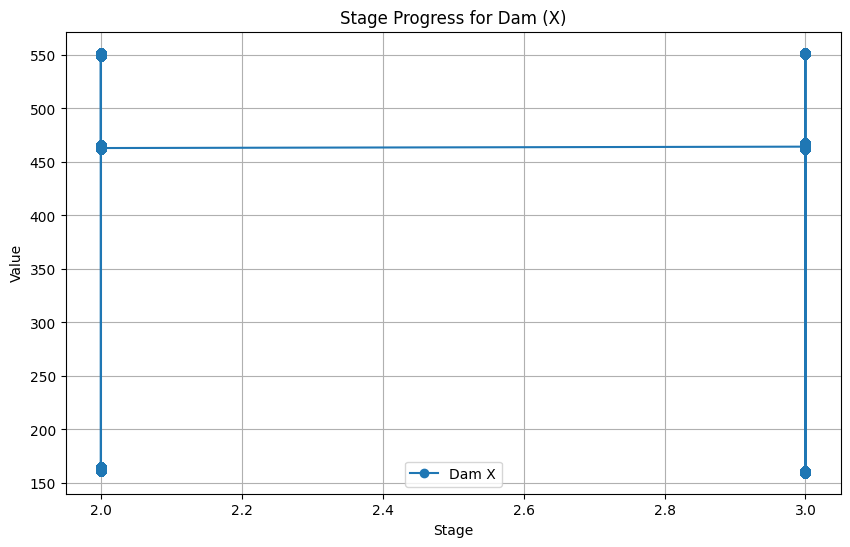

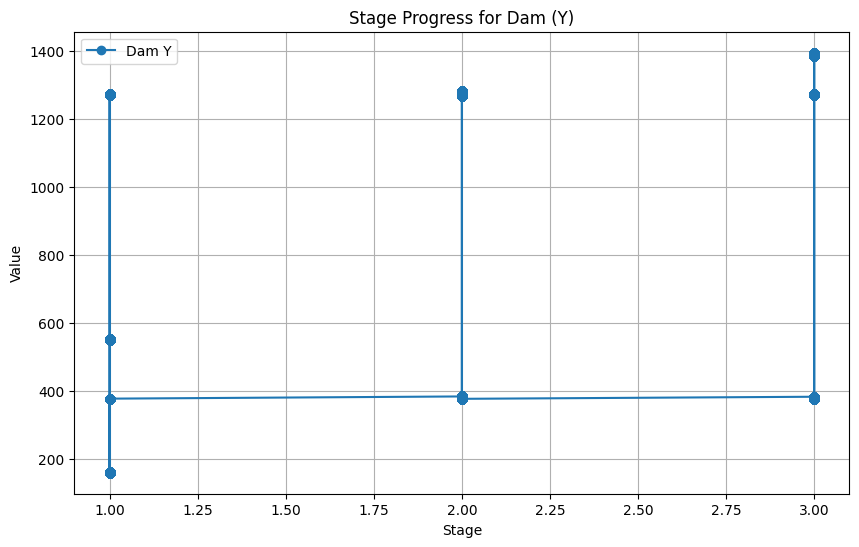

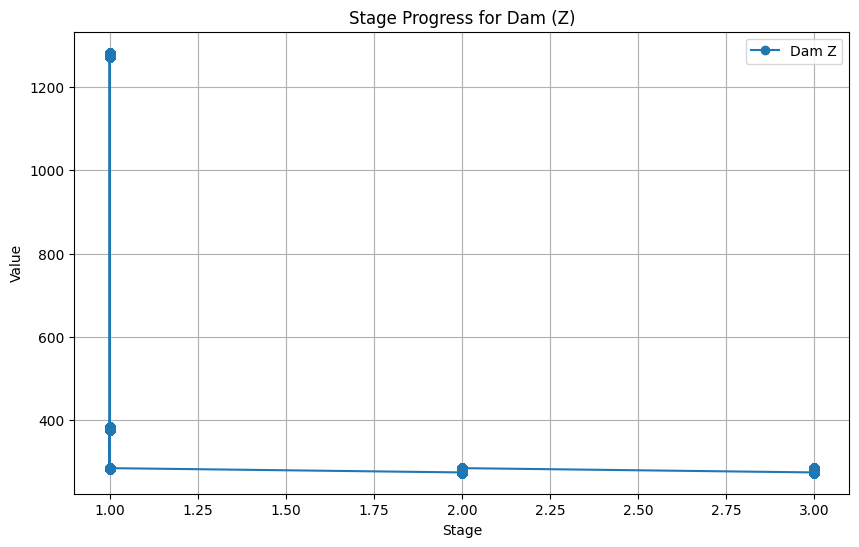

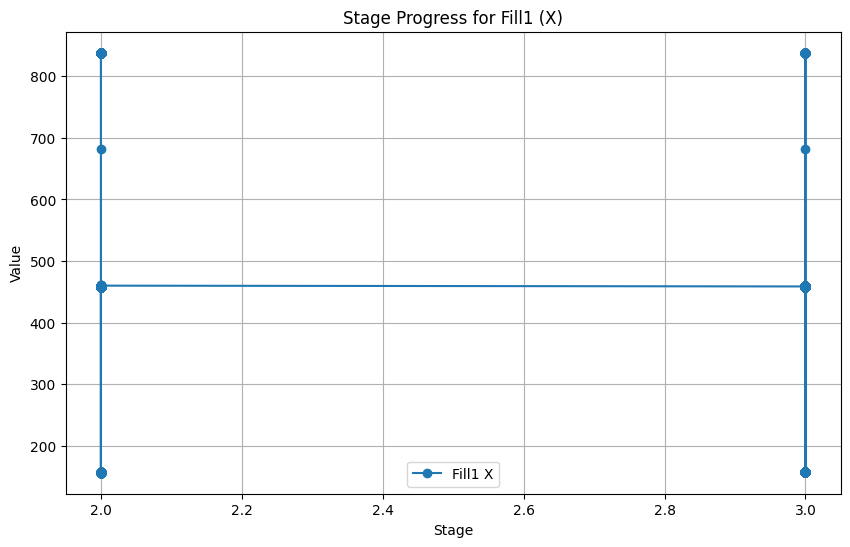

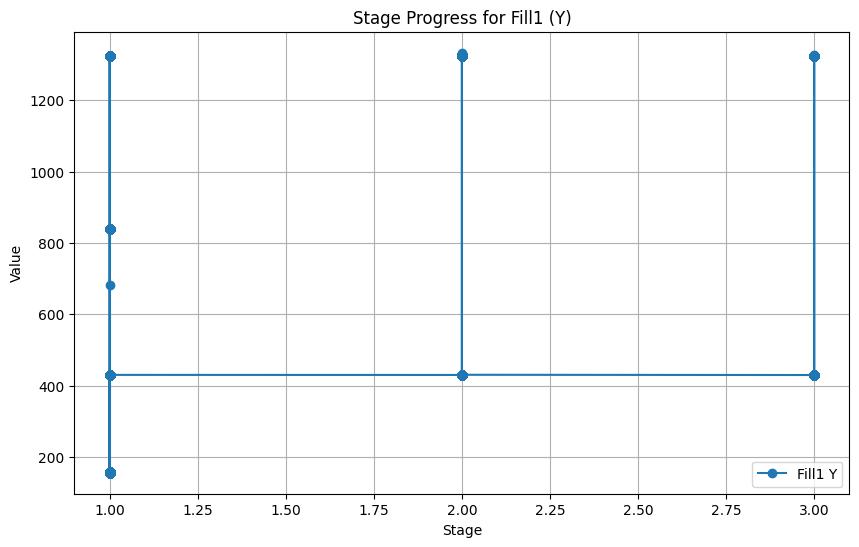

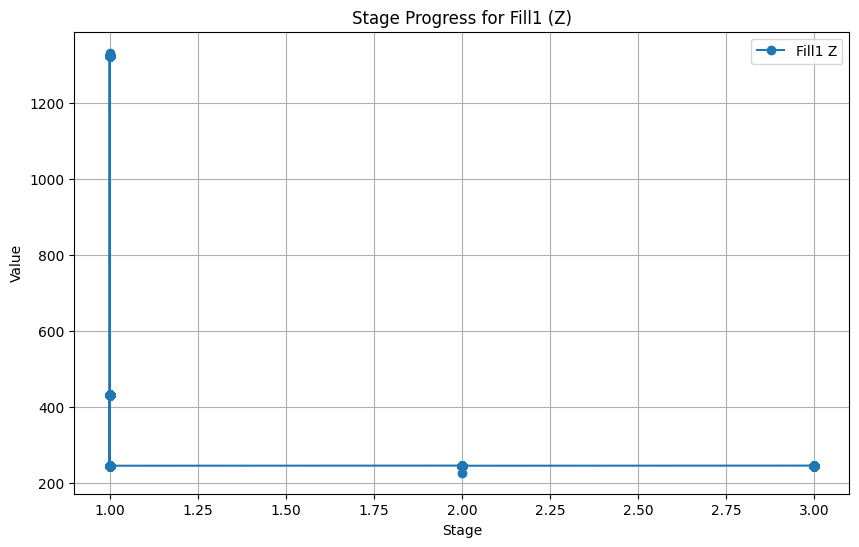

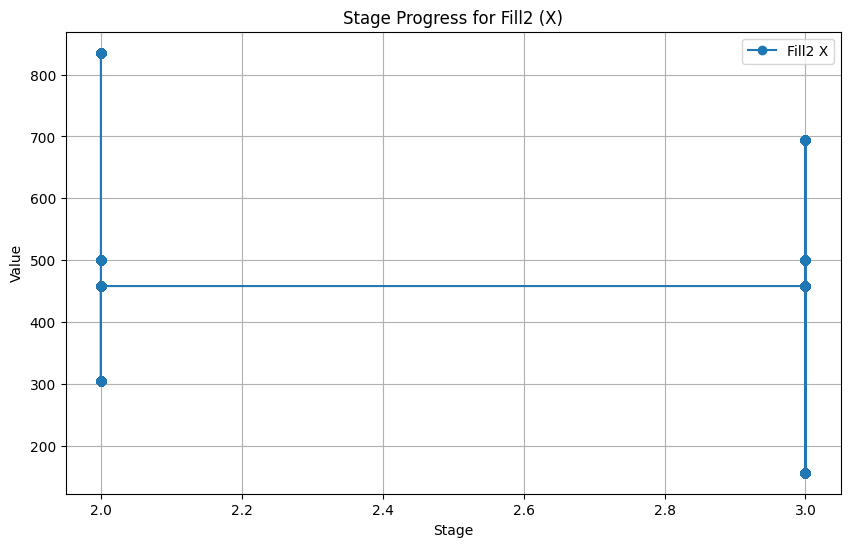

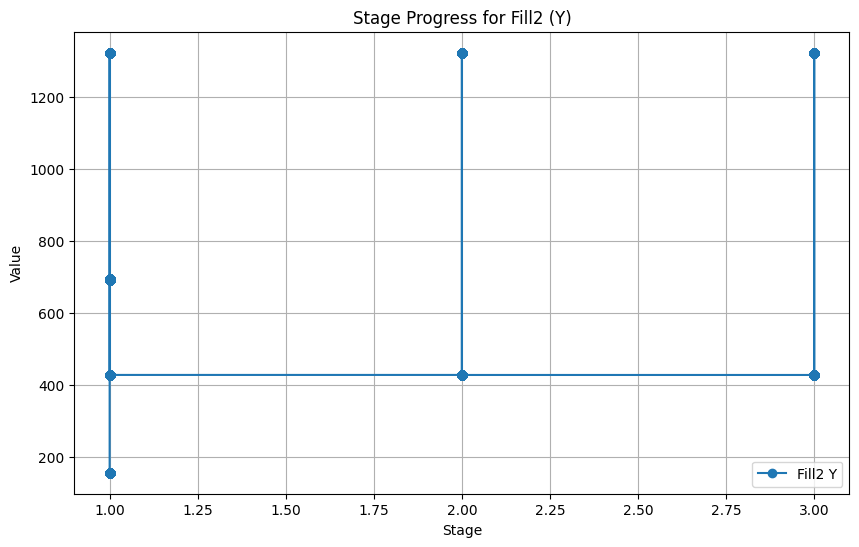

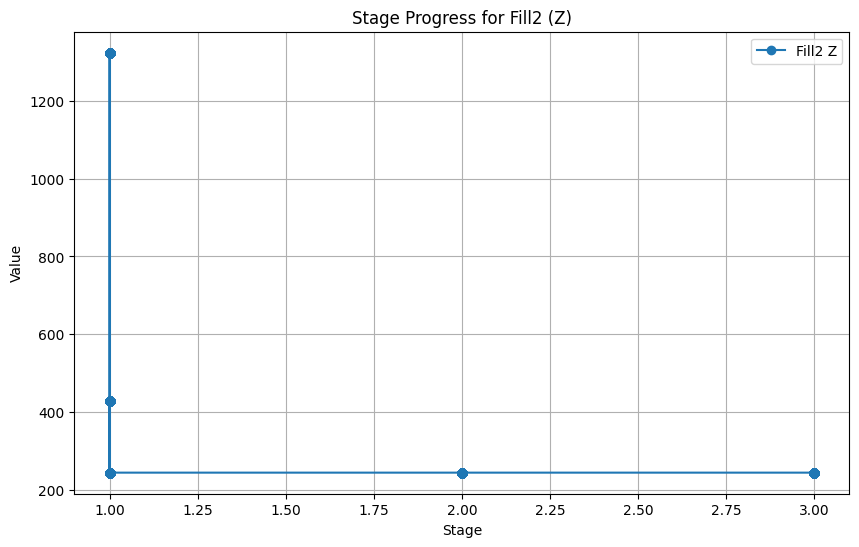

In [ ]:
# 시각화 함수 정의

# 각 점에 대한 클러스러팅을 진행 이후 해당 클러스터로부터 가장 많은 최빈값을 탐색 . 각 최빈값으로부터 떨어진 거리로 변수를 치환하기로 Insight를 얻음
def plot_stage_progress(df, process, axis):
    plt.figure(figsize=(10, 6))
    for proc in df['Process'].unique():
        if proc == process:
            df_proc = df[(df['Process'] == proc) & (df['Axis'] == axis)]
            plt.plot(df_proc['Stage'], df_proc['Value'], marker='o', label=f'{proc} {axis}')

    plt.title(f'Stage Progress for {process} ({axis})')
    plt.xlabel('Stage')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# 'Dam', 'Fill1', 'Fill2'에 대해 각각 시각화
for process in ['Dam', 'Fill1', 'Fill2']:
    for axis in ['X', 'Y', 'Z']:
        plot_stage_progress(df_melted, process, axis)


In [ ]:
df_COORDINATE

,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,...,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2
0,550.5,464.3,161.4,384.0,383.1,384.00,274.51,274.51,838.4,458.7,...,244.520,244.520,835.5,458.0,156.0,428.0,427.9,428.0,243.7,243.7
1,463.8,160.8,377.3,377.3,377.3,282.15,282.15,282.15,458.5,157.0,...,244.400,244.400,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7
2,162.4,465.4,551.7,1271.8,1383.9,1271.80,274.33,274.33,837.9,458.1,...,244.415,244.415,305.0,499.8,694.0,1324.2,1324.2,1324.2,243.5,243.5
3,465.5,552.0,1271.8,1270.7,1271.8,282.15,282.15,282.15,458.8,157.0,...,244.300,244.300,499.8,694.0,1324.2,1324.2,1324.2,243.5,243.5,243.5
4,462.5,159.5,377.5,377.0,377.5,284.80,284.80,284.80,458.5,157.0,...,244.400,244.400,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,463.8,160.8,377.3,377.3,377.3,282.15,282.15,282.15,458.5,157.0,...,244.400,244.400,458.0,156.0,428.0,427.9,428.0,243.7,243.7,243.7
40502,163.5,466.2,553.1,1281.0,1393.5,1281.20,274.33,274.33,838.1,458.7,...,244.535,244.535,304.8,499.8,692.8,1324.2,1324.2,1324.2,243.5,243.5
40503,550.6,463.9,161.5,377.6,377.1,378.00,274.78,274.78,838.4,458.4,...,244.543,244.543,835.5,458.0,156.0,428.0,427.9,428.0,243.7,243.7
40504,465.1,551.3,1269.0,1268.4,1269.0,282.15,282.15,282.15,458.8,157.0,...,244.400,244.400,499.8,694.0,1324.2,1324.2,1324.2,243.5,243.5,243.5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats

# 가상의 데이터프레임 df_POSITION 준비
# 이 코드는 데이터가 이미 있다고 가정하고 시작합니다.

# 결과 저장용 딕셔너리
results = {}

# 각 칼럼에 대해 처리
for column in df_COORDINATE.columns:
    if df_COORDINATE[column].nunique() > 1:  # 유효한 클러스터링을 위해 유일한 값이 두 개 이상인 경우에만 진행
        print(f"Processing column: {column}")

        # 결측값 제거
        data = df_COORDINATE[[column]].dropna()

        # 데이터 정규화
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)

        # 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
        inertia = []
        silhouette_scores = []
        k_range = range(2, 11)  # 2부터 10까지의 클러스터 개수에 대해 평가

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data_scaled)
            inertia.append(kmeans.inertia_)
            silhouette_avg = silhouette_score(data_scaled, kmeans.labels_)
            silhouette_scores.append(silhouette_avg)

        # 최적의 클러스터 수 선택 (실루엣 점수가 가장 높은 k 선택)
        optimal_clusters = k_range[np.argmax(silhouette_scores)]

        # 최적의 클러스터 수로 KMeans 클러스터링 적용
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
        data['Cluster'] = kmeans.fit_predict(data_scaled)

        # 클러스터별 최빈값 계산
        mode_per_cluster = data.groupby('Cluster')[column].apply(lambda x: stats.mode(x, keepdims=True)[0][0] if not x.empty else np.nan)

        # 각 데이터 포인트와 클러스터의 최빈값 간의 거리 계산
        def calculate_distance(row):
            cluster = row['Cluster']
            cluster_mode = mode_per_cluster.get(cluster, np.nan)
            if pd.notna(cluster_mode):
                return abs(row[column] - cluster_mode)
            else:
                return np.nan

        data['Distance_from_Mode'] = data.apply(calculate_distance, axis=1)

        # 결과 저장
        results[column] = data[['Cluster', 'Distance_from_Mode']]
        print(f"Finished processing column: {column}")

# 최종 결과 확인
for column, result in results.items():
    print(f"Results for column: {column}")
    print(result.head())


Processing column: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Finished processing column: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
Processing column: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

KeyboardInterrupt: 

,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,...,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2
0,0.1,2.8,0.1,6.4,6.0,6.40,0.18,0.18,0.0,0.4,...,0.015,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8,0.3,0.2,0.3,0.2,0.00,0.00,0.00,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.7,174.2,0.0,0.0,0.00,0.00,0.00,0.5,0.2,...,0.015,0.015,0.0,41.8,266.0,0.0,0.0,0.0,0.0,0.0
3,2.5,0.7,2.8,1.1,1.1,0.00,0.00,0.00,0.3,0.0,...,0.100,0.000,41.8,0.0,0.0,0.0,0.0,0.2,0.0,0.0
4,0.5,1.0,0.0,0.6,0.4,2.65,0.00,0.00,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,0.8,0.3,0.2,0.3,0.2,0.00,0.00,0.00,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40502,1.1,0.9,175.6,0.0,9.6,9.40,0.00,0.00,0.3,0.4,...,0.030,0.030,0.2,41.8,264.8,0.0,0.0,0.0,0.0,0.0
40503,0.2,3.2,0.2,0.0,0.0,0.40,0.45,0.45,0.0,0.1,...,0.038,0.038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40504,2.1,0.0,0.0,3.4,1.7,0.00,0.00,0.00,0.3,0.0,...,0.000,0.000,41.8,0.0,0.0,0.0,0.0,0.2,0.0,0.0


In [ ]:
 cluster_results[f"{column}_Clustered_mod"] = mode_per_cluster

NameError: name 'mode_per_cluster' is not defined

In [ ]:
df_POSITION = train_not_null[POSITION_columns_nnull]

In [ ]:
# 각 점에 대한 클러스러팅을 진행 이후 해당 클러스터로부터 가장 많은 최빈값을 탐색 . 각 최빈값으로부터 떨어진 거리로 변수를 치환하기로 Insight를 얻음

columns = POSITION_columns_nnull
data = []

for col in columns:
    parts = col.split()

    # 기기 구분
    device = 'Unknown'
    if parts[0] in ['CURE', 'HEAD', 'Head']:
        device = 'CURE' if parts[0] == 'CURE' else 'HEAD'

    # 상태 구분
    state = 'Unknown'
    if 'END' in parts:
        state = 'END'
    elif 'STANDBY' in parts:
        state = 'STANDBY'
    elif 'START' in parts:
        state = 'START'
    elif 'Clean' in parts:
        state = 'Clean'
    elif 'Purge' in parts:
        state = 'Purge'
    elif 'Zero' in parts:
        state = 'Zero'

    # 축 구분
    axis = parts[-3] if parts[-3] in ['X', 'Y', 'Z', 'Θ'] else 'Unknown'

    # 공정 구분
    process = parts[-1].split('_')[-1]

    # 컬럼에서 Value 추출 (여기서는 예시로 랜덤 값 사용)
    value = df_POSITION[col]  # 실제 Value 값은 이 컬럼에서 추출

    # 각 항목을 데이터에 추가
    for v in value:
        data.append({
            'Device': device,
            'State': state,
            'Axis': axis,
            'Process': process,
            'Value': v
        })

# 데이터 프레임 생성
df_positions = pd.DataFrame(data)

# 결과 출력
print(df_positions.head())

  Device State Axis Process   Value
0   CURE   END    X     Dam   240.0
1   CURE   END    X     Dam   240.0
2   CURE   END    X     Dam  1000.0
3   CURE   END    X     Dam  1000.0
4   CURE   END    X     Dam   240.0


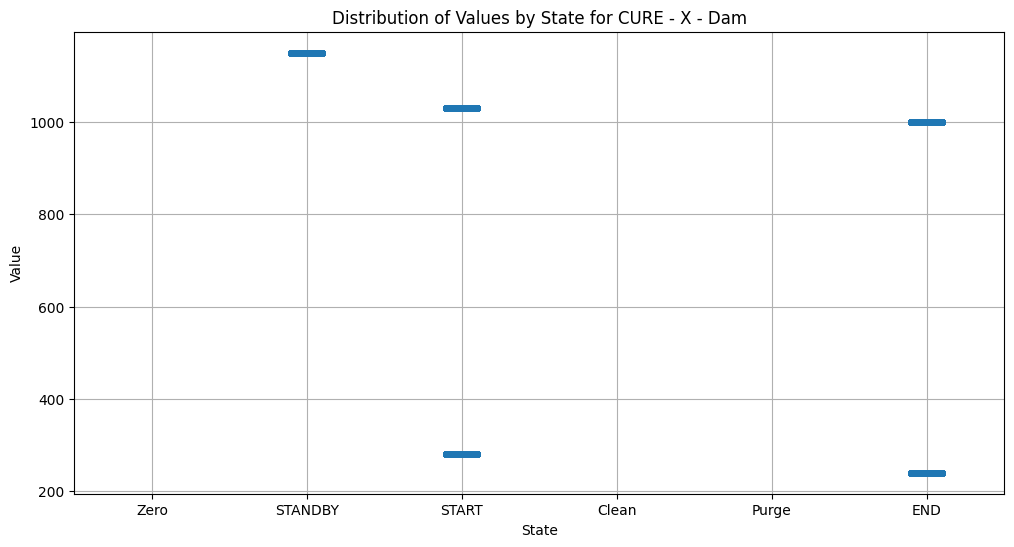

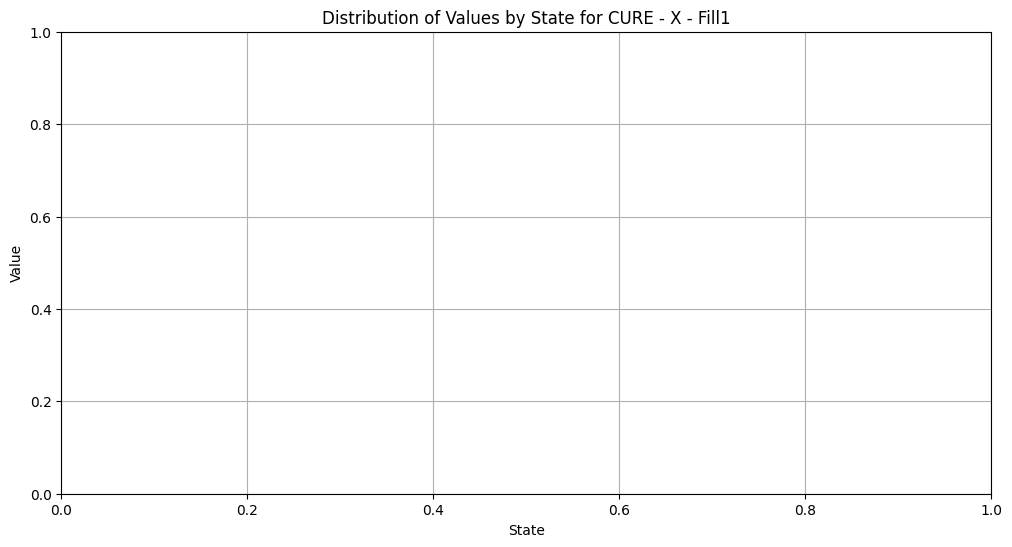

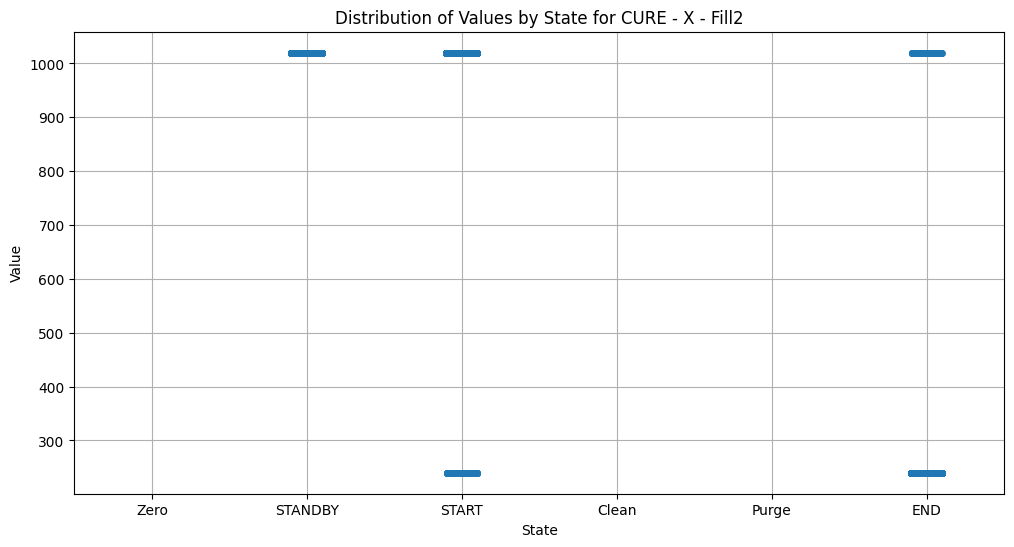

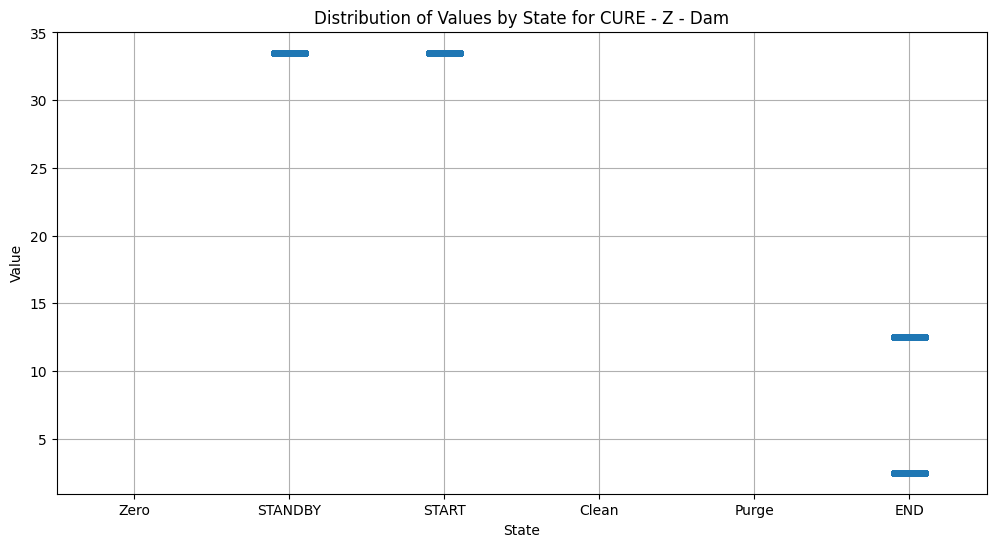

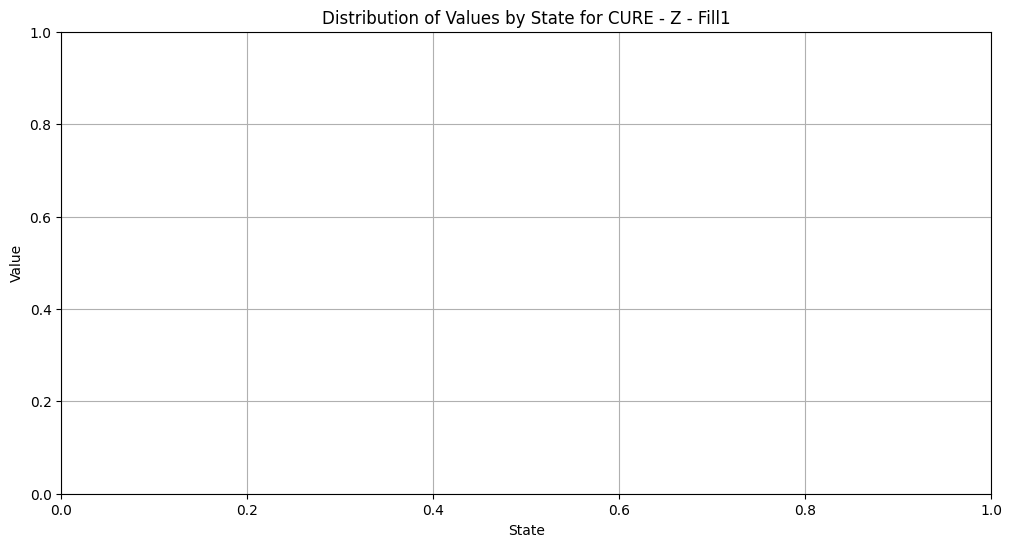

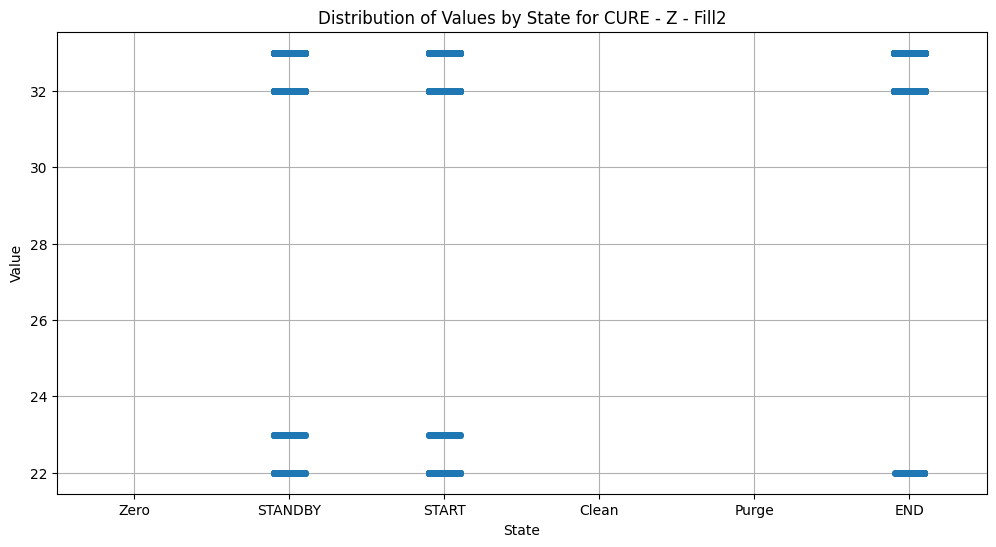

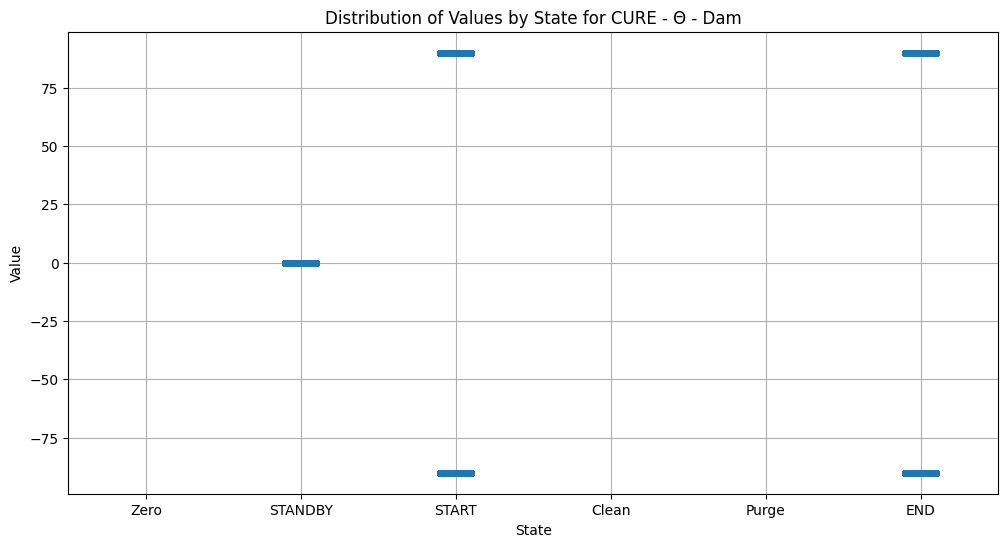

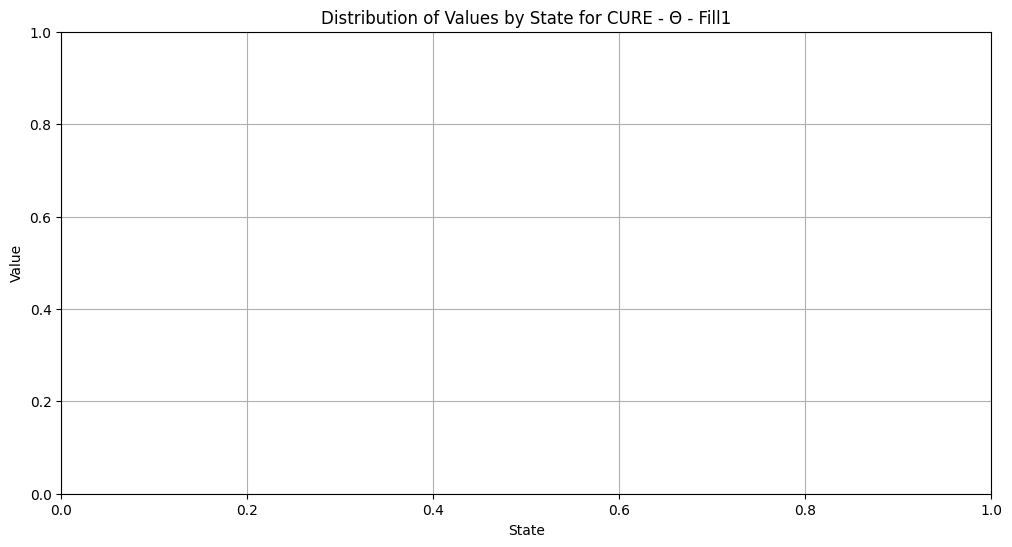

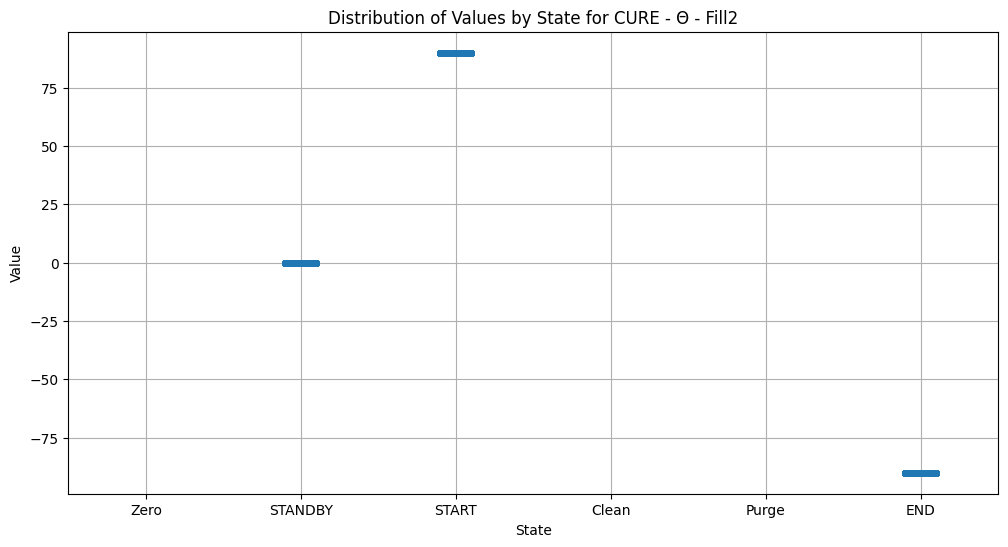

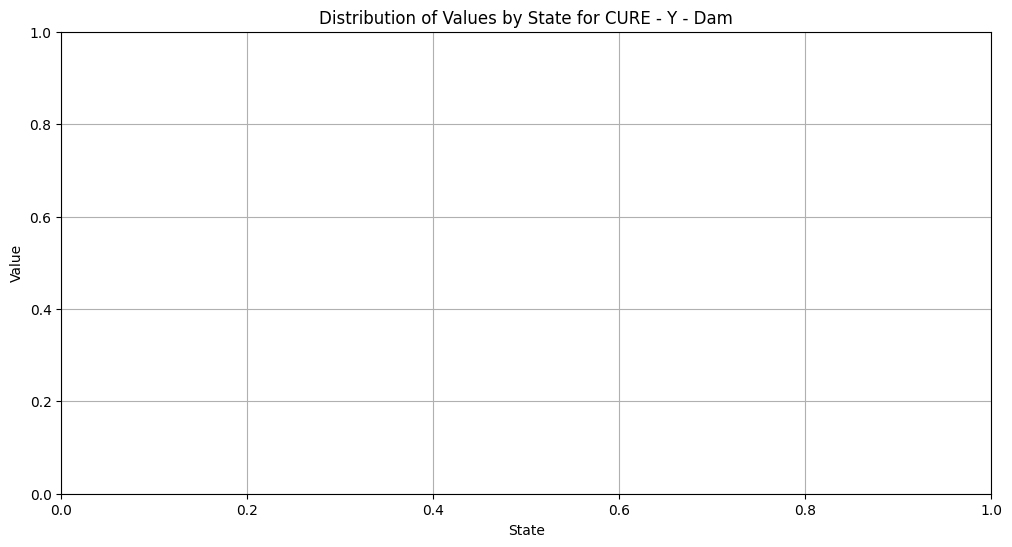

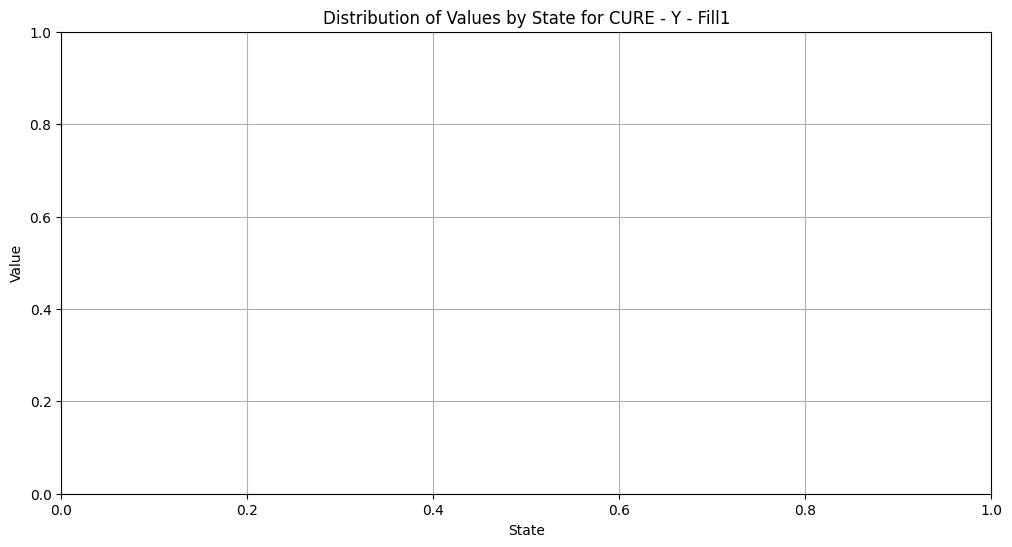

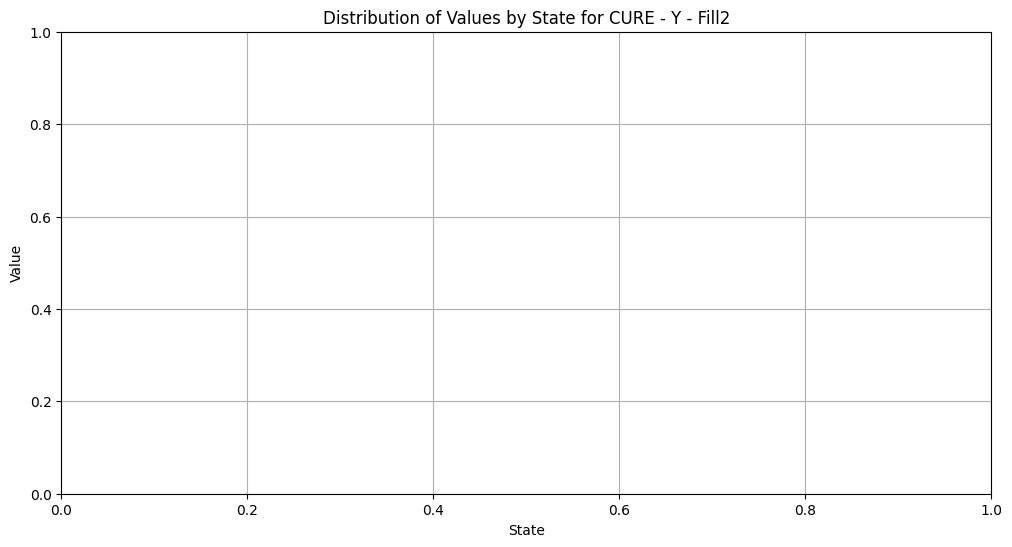

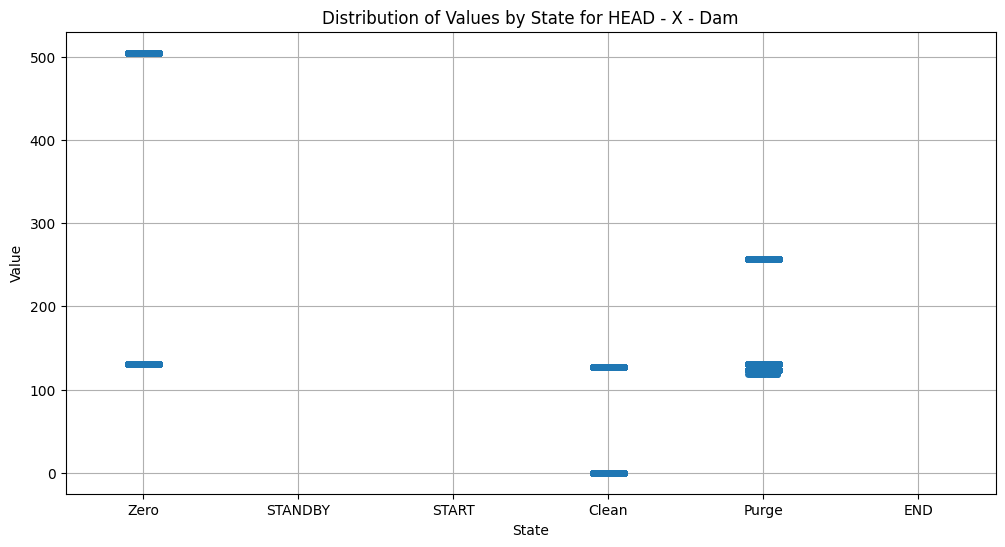

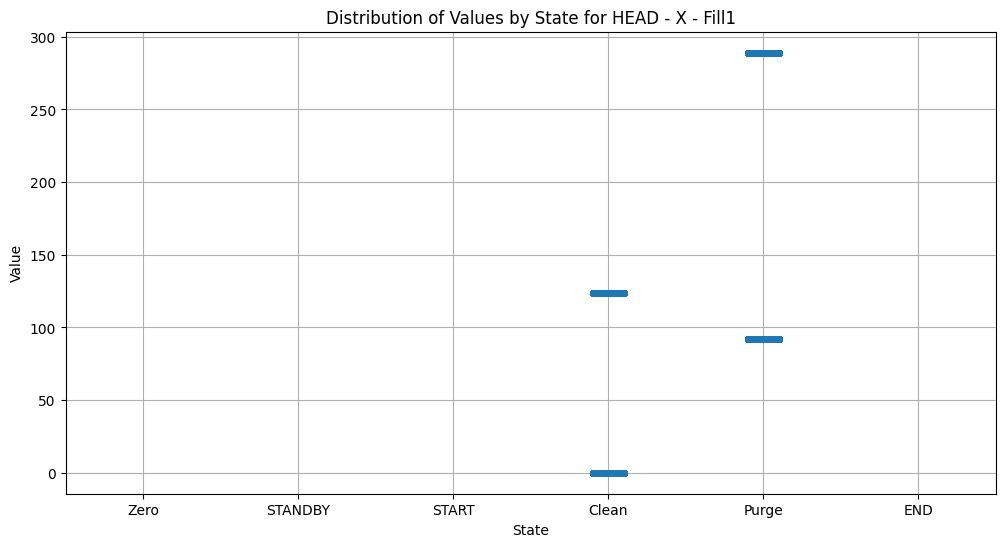

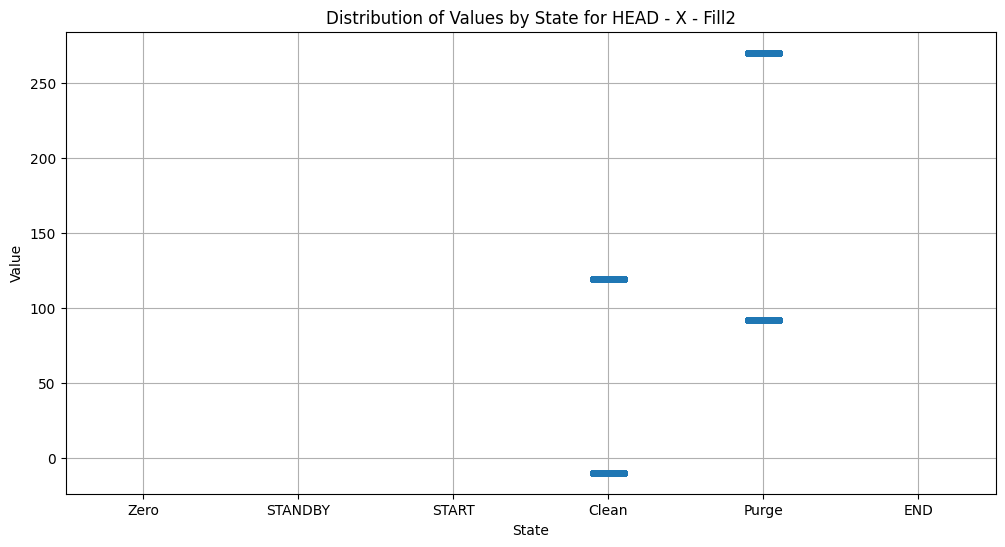

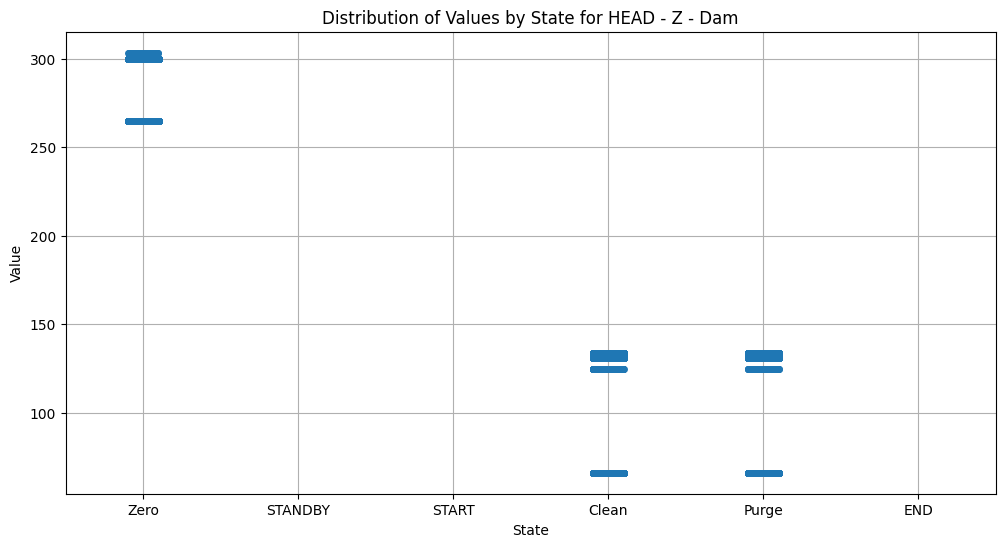

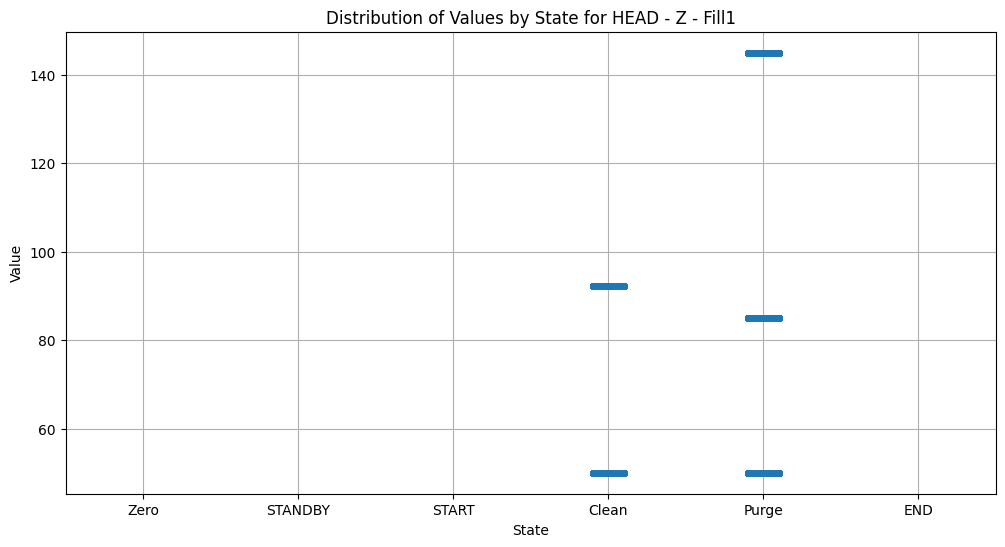

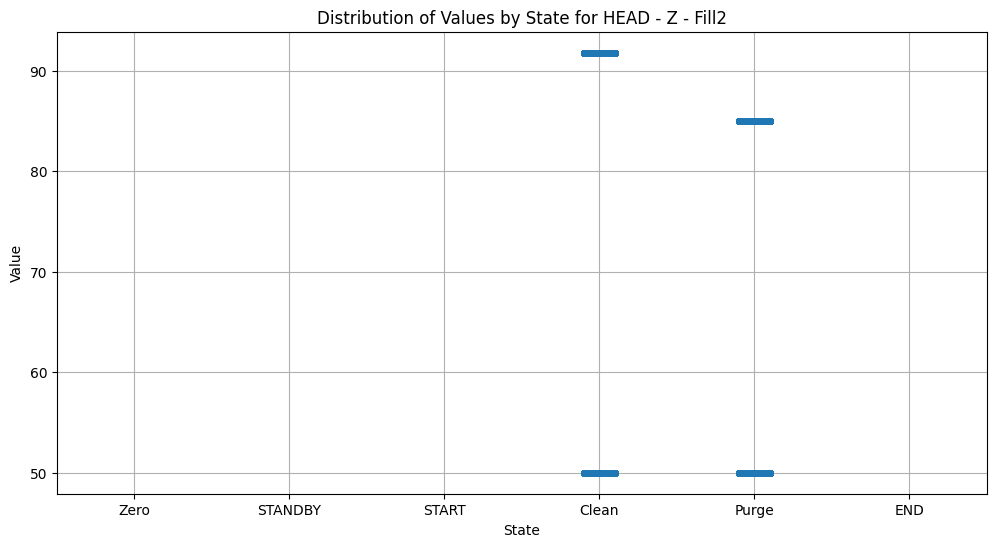

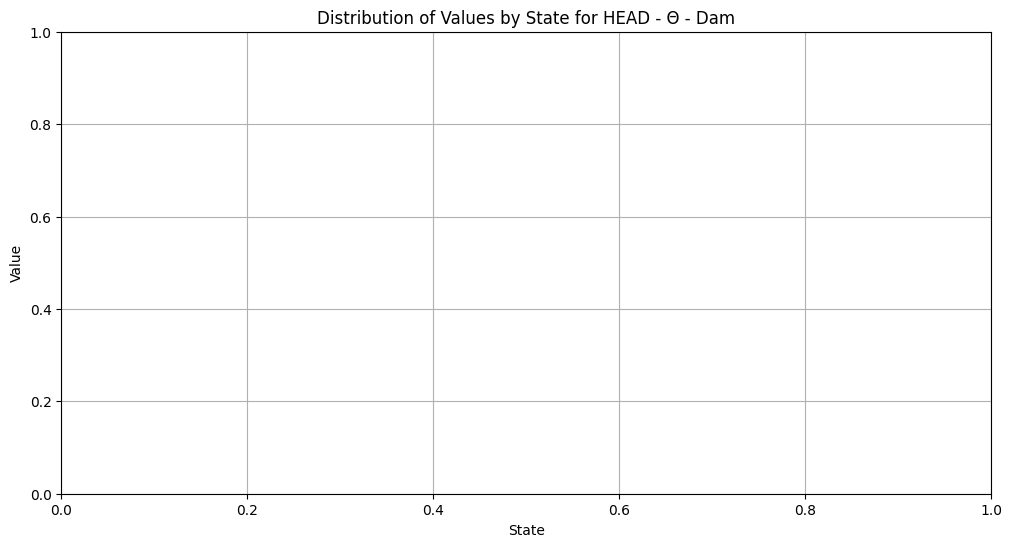

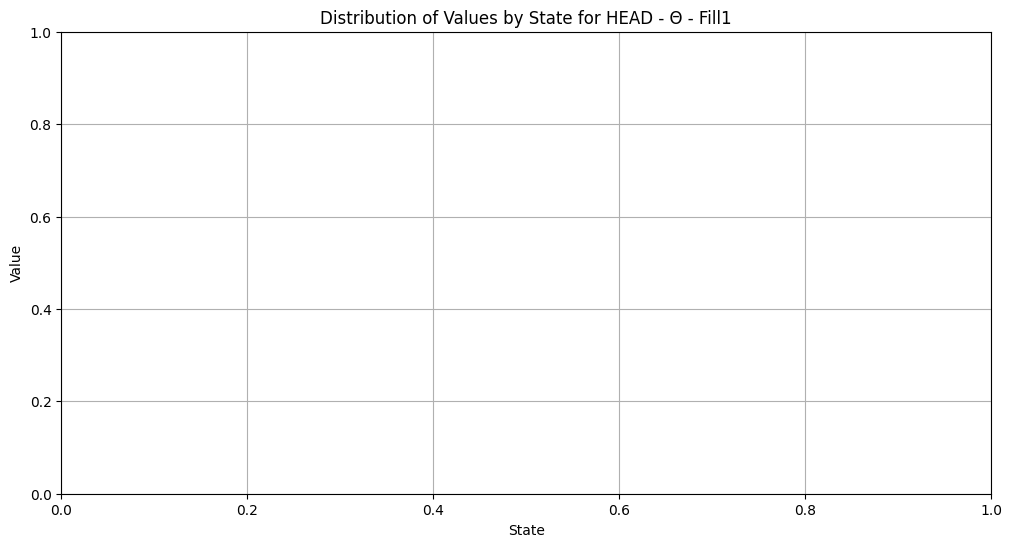

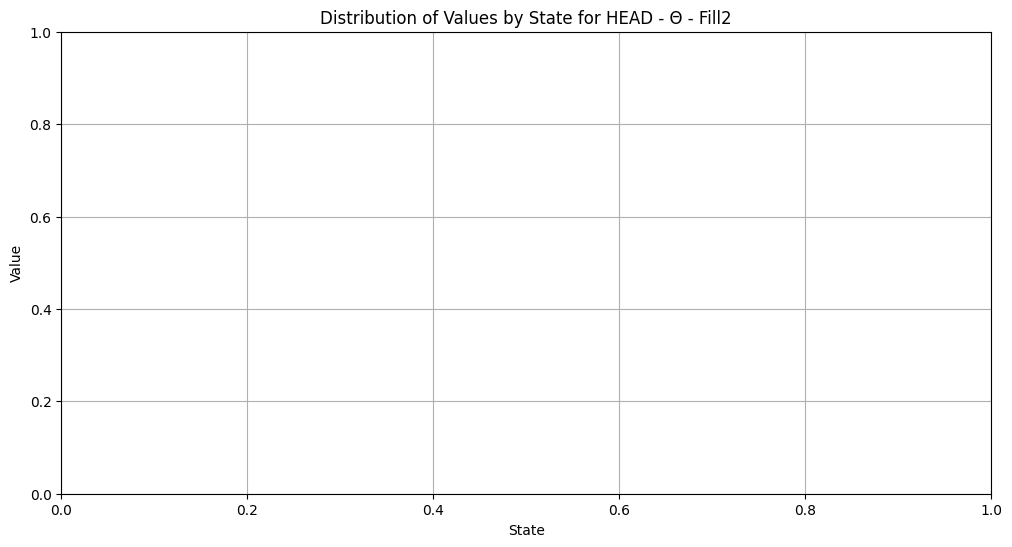

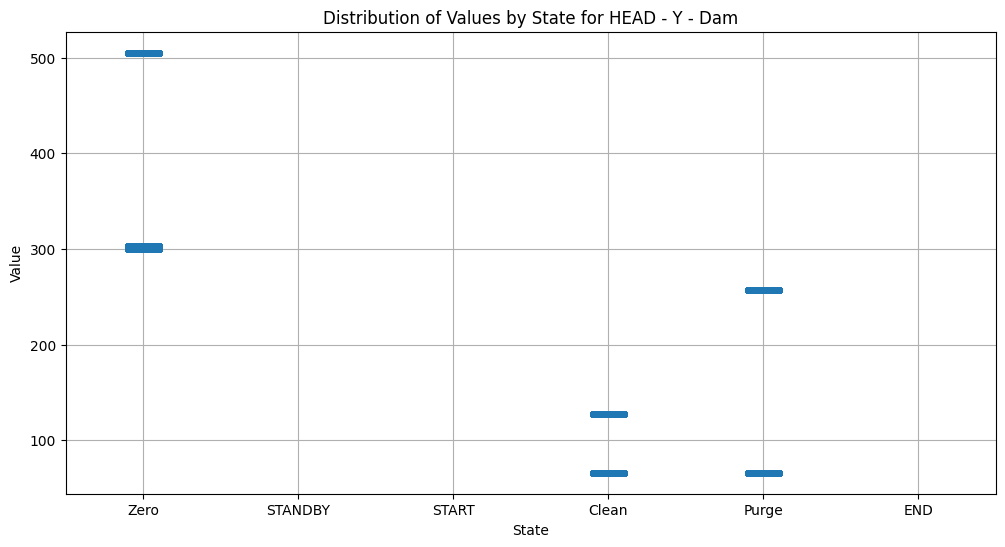

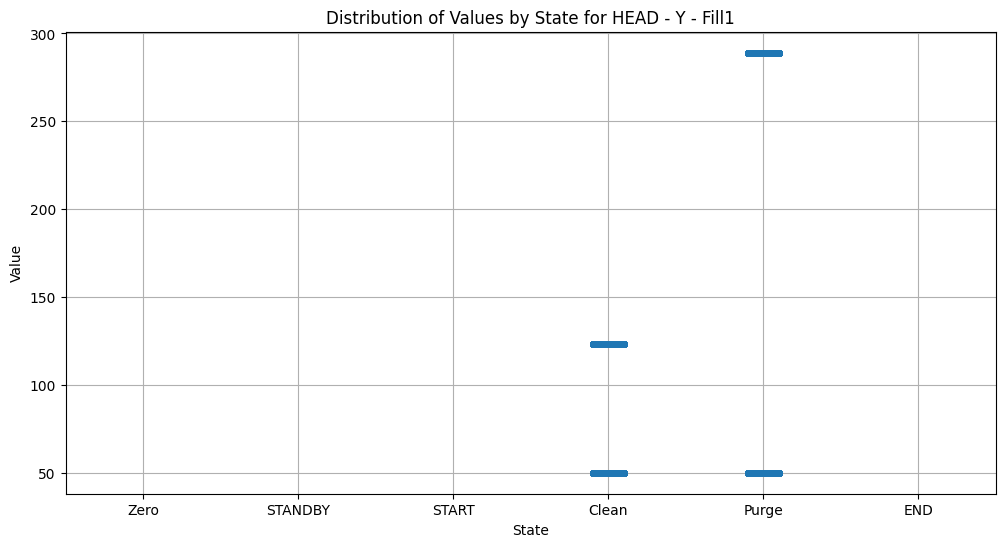

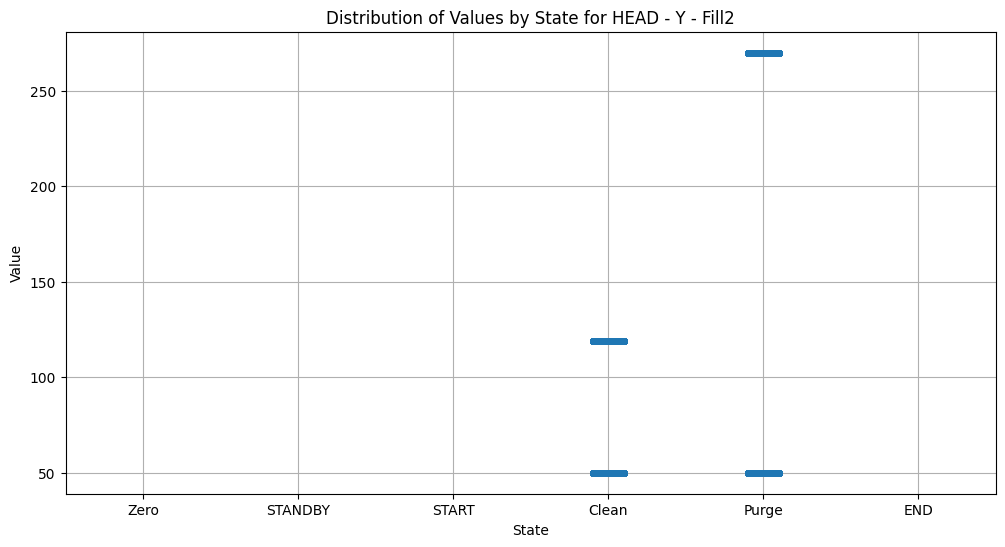

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상태 순서 정의
state_order = ['Zero', 'STANDBY', 'START', 'Clean', 'Purge', 'END']


# 시각화 함수 정의
def plot_state_value(df, device, axis, process):
    # 해당 조건에 맞는 데이터 필터링
    df_filtered = df[(df['Device'] == device) &
                     (df['Axis'] == axis) &
                     (df['Process'] == process)]

    plt.figure(figsize=(12, 6))

    # 상태 순서에 맞춰 stripplot 생성
    sns.stripplot(x='State', y='Value', data=df_filtered, order=state_order, jitter=True)

    plt.title(f'Distribution of Values by State for {device} - {axis} - {process}')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# 시각화 예시
devices = df_positions['Device'].unique()
axes = df_positions['Axis'].unique()
processes = df_positions['Process'].unique()

for device in devices:
    for axis in axes:
        for process in processes:
            plot_state_value(df_positions, device, axis, process)


In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 상태 순서 정의
# state_order = ['Zero', 'STANDBY', 'START', 'Clean', 'Purge', 'END']

# # 시각화 함수 정의
# def plot_state_value_swarm(df, device, axis, process):
#     # 해당 조건에 맞는 데이터 필터링
#     df_filtered = df[(df['Device'] == device) &
#                      (df['Axis'] == axis) &
#                      (df['Process'] == process)]

#     plt.figure(figsize=(12, 6))

#     # 상태 순서에 맞춰 swarmplot 생성
#     sns.swarmplot(x='State', y='Value', data=df_filtered, order=state_order, marker='o')

#     plt.title(f'Distribution of Values by State for {device} - {axis} - {process}')
#     plt.xlabel('State')
#     plt.ylabel('Value')
#     plt.grid(True)
#     plt.show()

# # 시각화 예시
# devices = df_positions['Device'].unique()
# axes = df_positions['Axis'].unique()
# processes = df_positions['Process'].unique()

# for device in devices:
#     for axis in axes:
#         for process in processes:
#             plot_state_value_swarm(df_positions, device, axis, process)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79fecb370670> (for post_execute):


KeyboardInterrupt: 

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


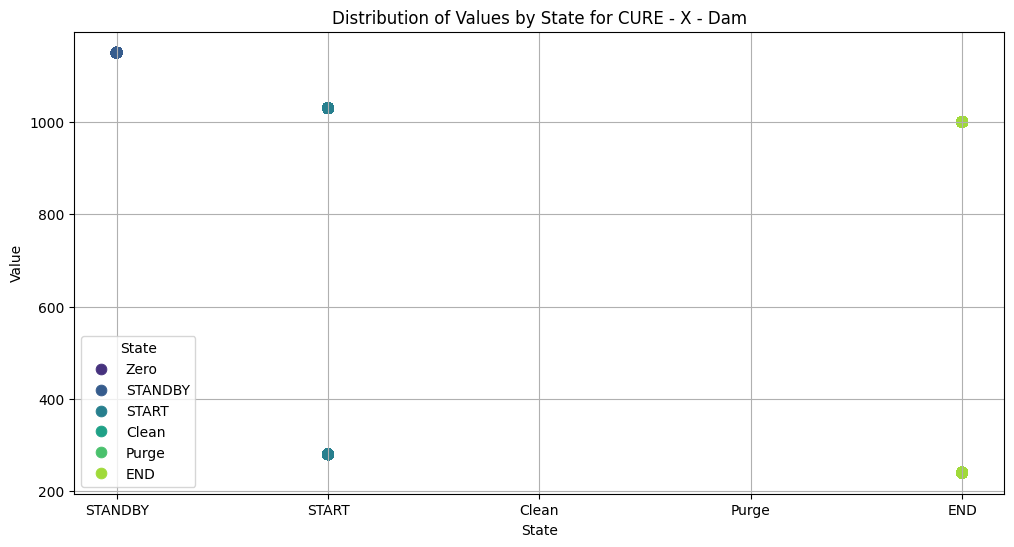

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


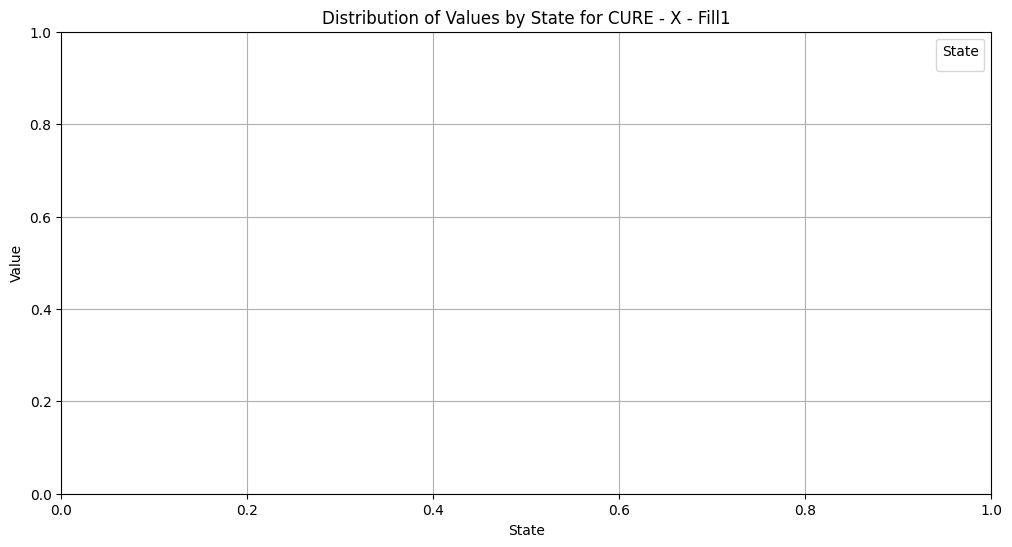

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


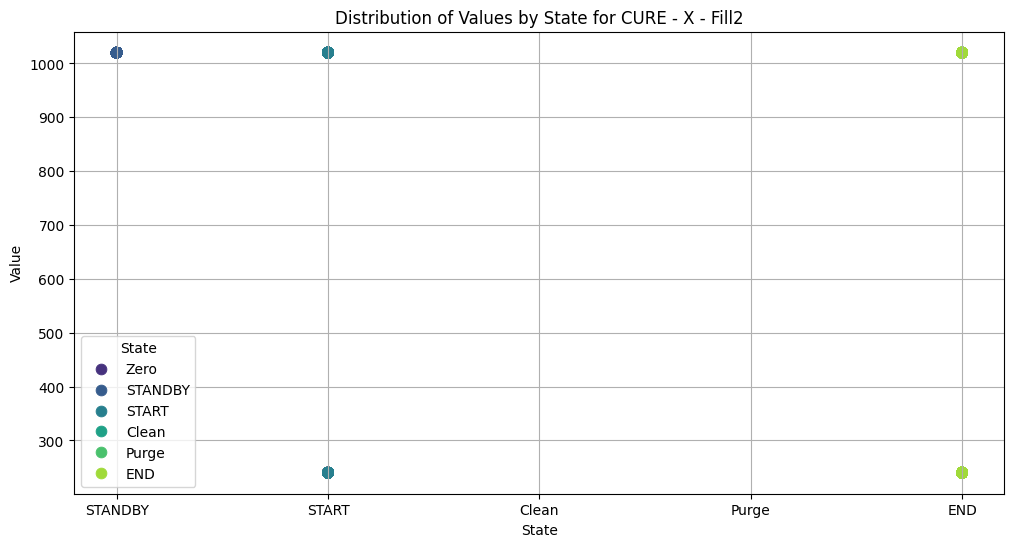

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


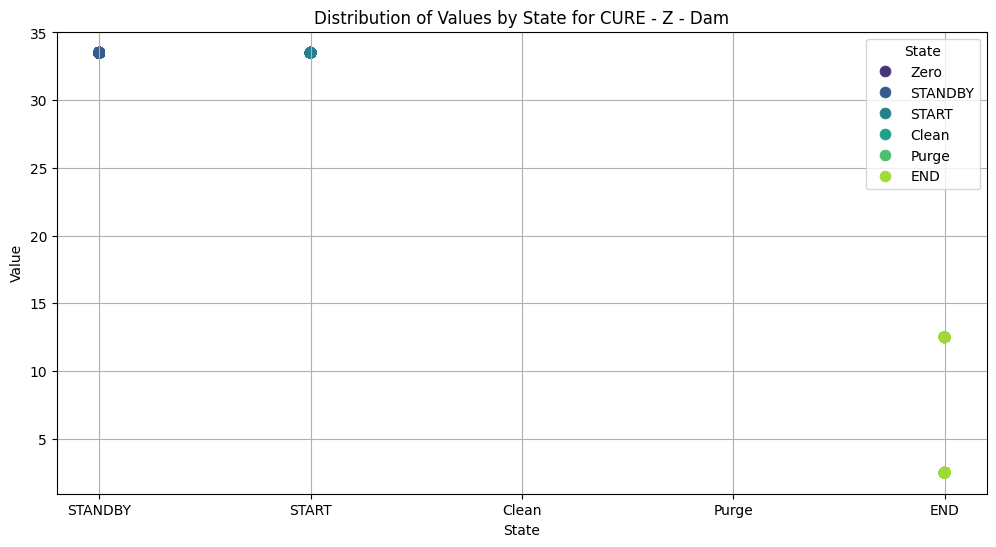

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


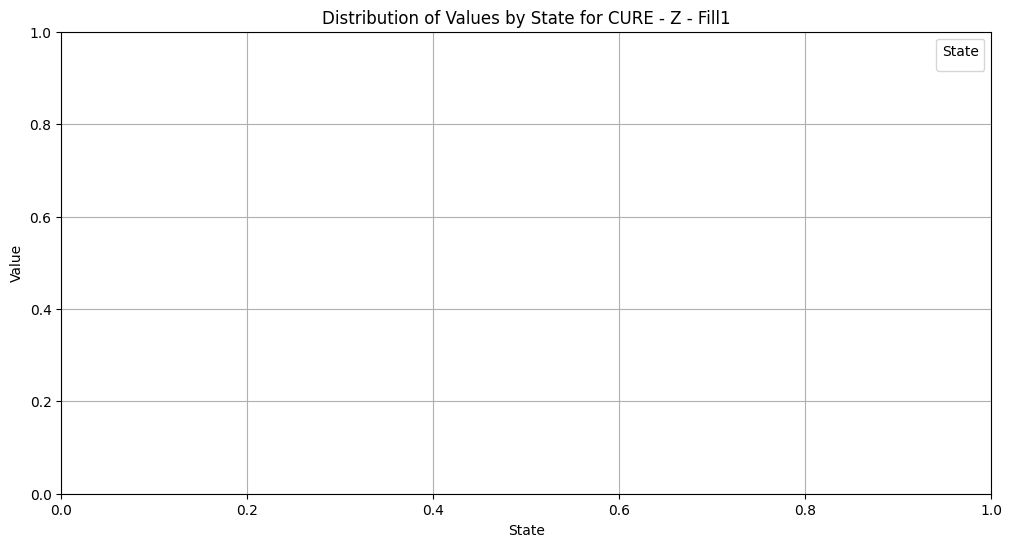

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


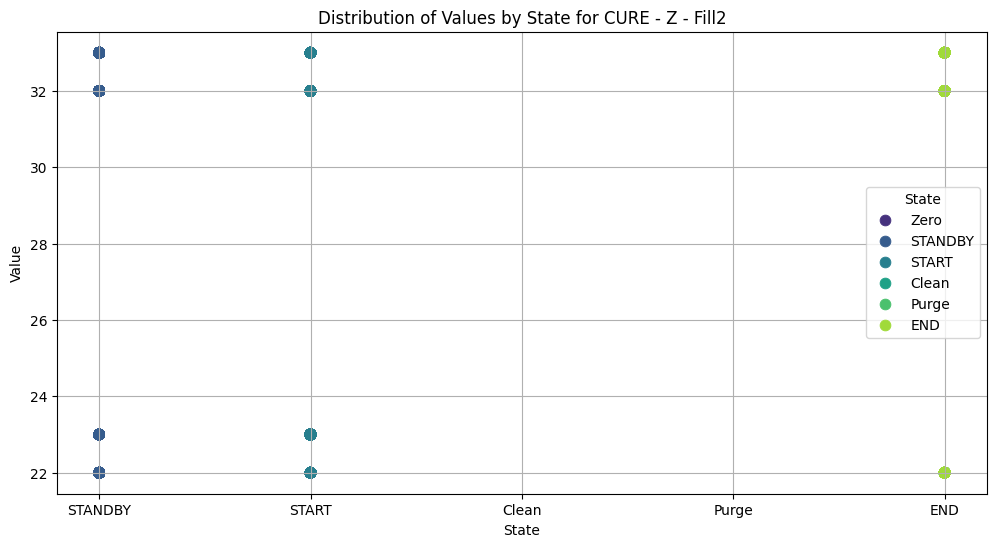

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


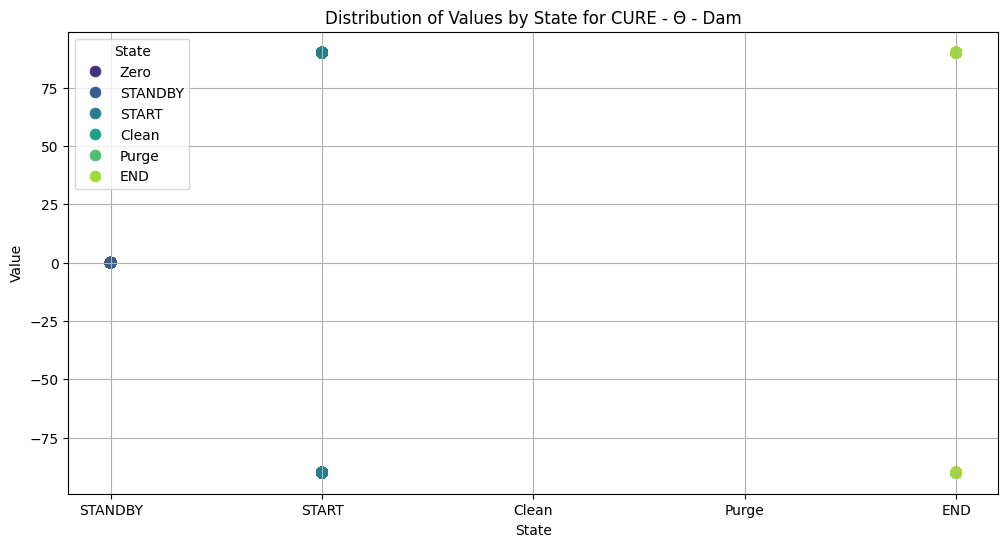

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


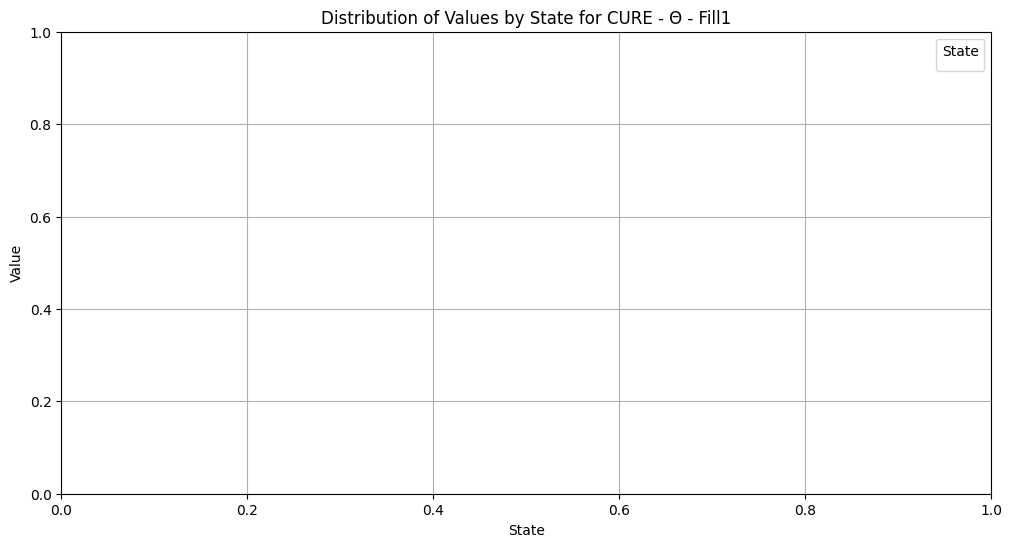

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


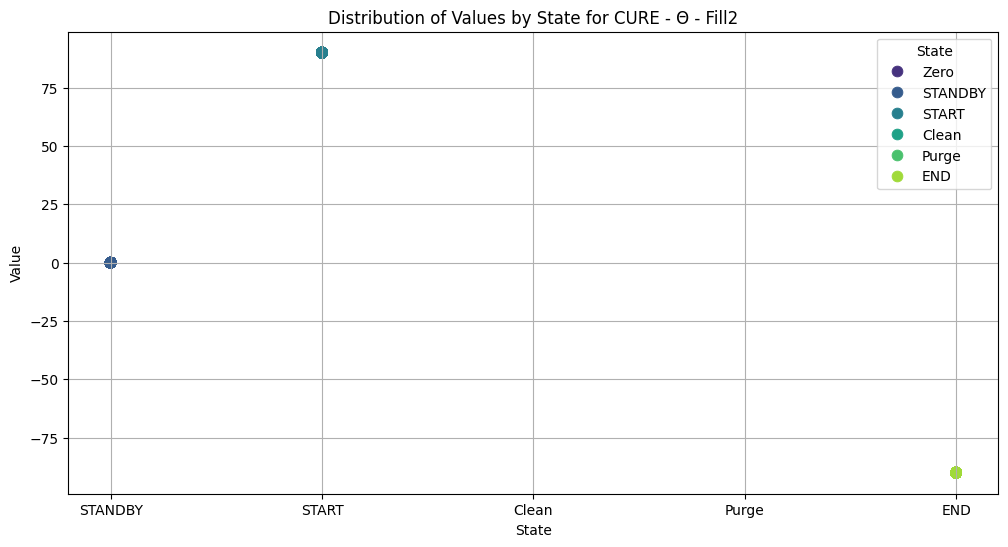

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


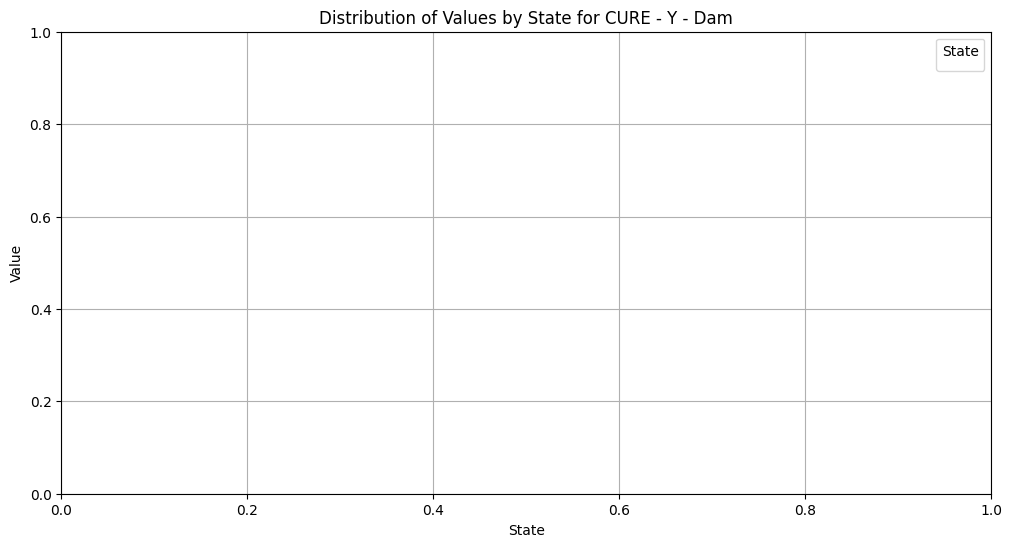

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


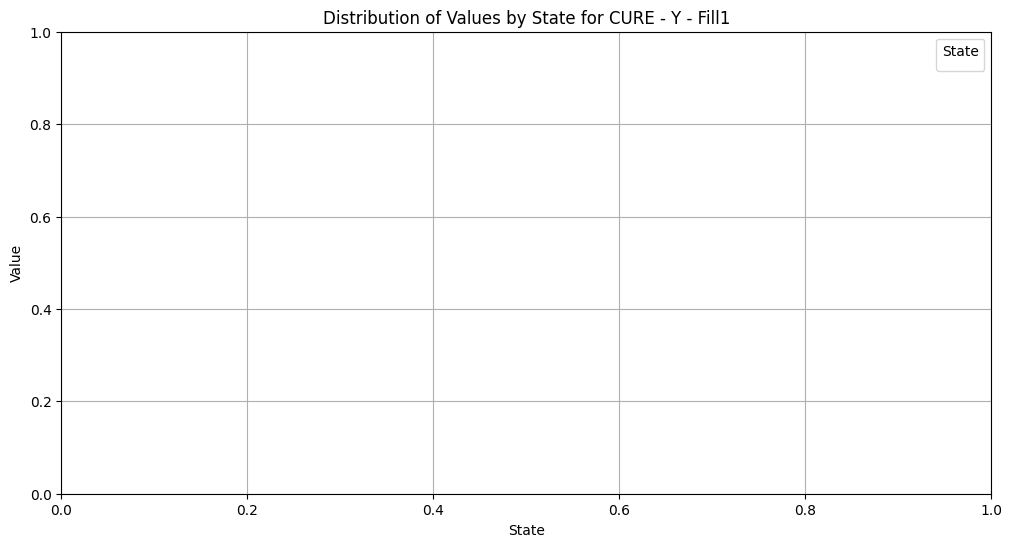

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


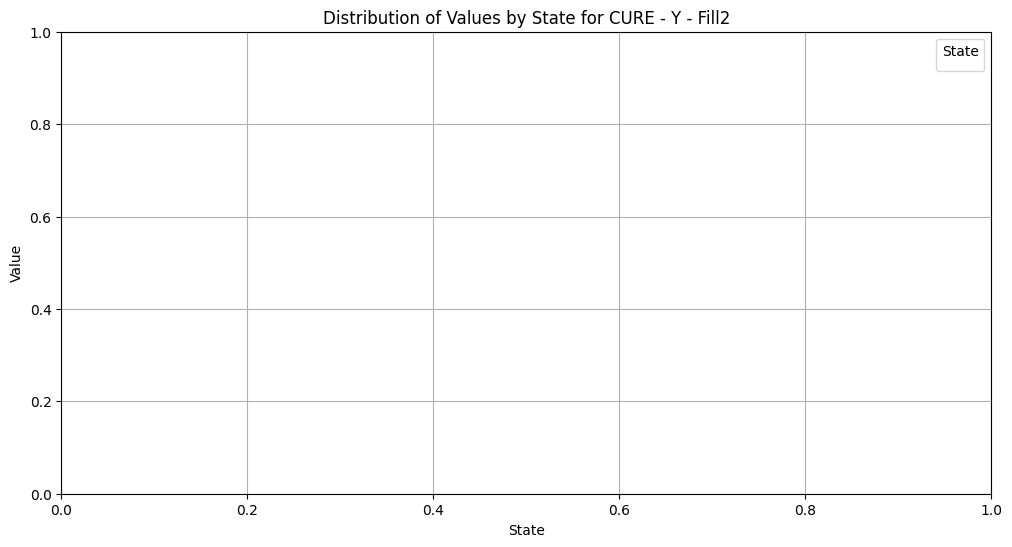

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


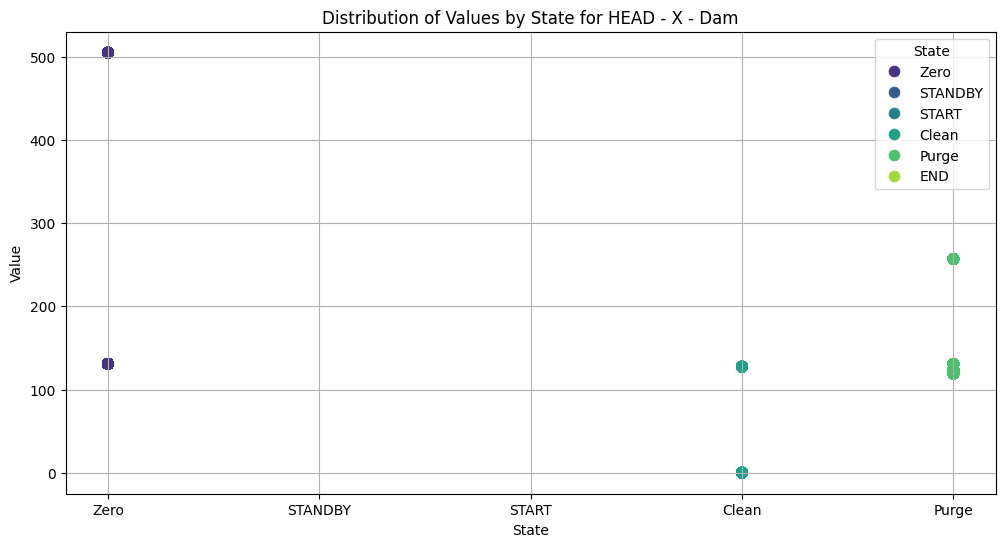

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


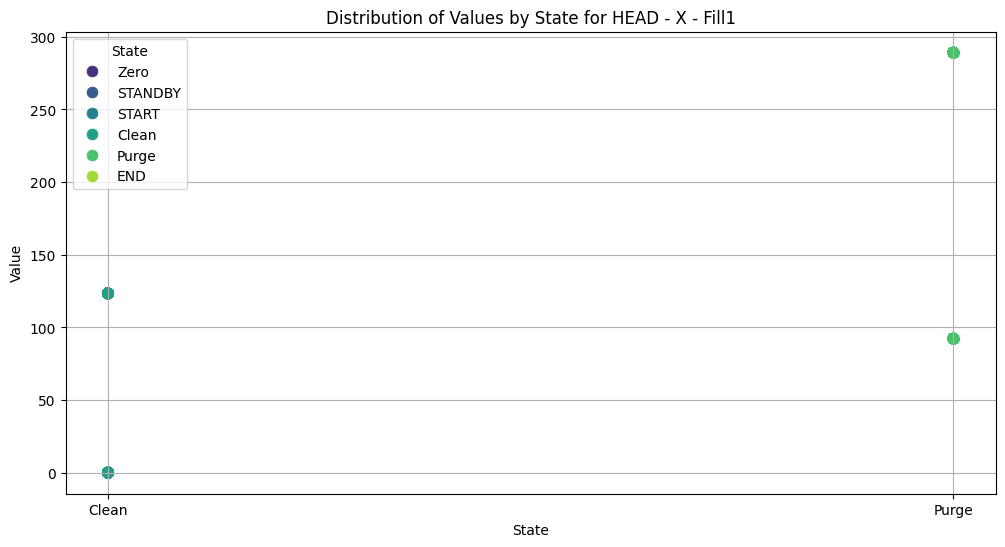

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


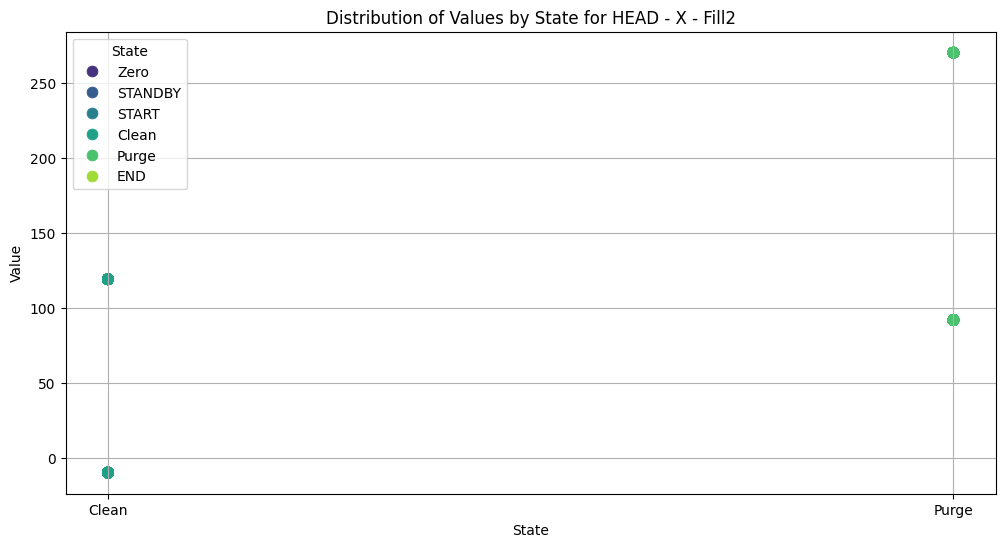

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


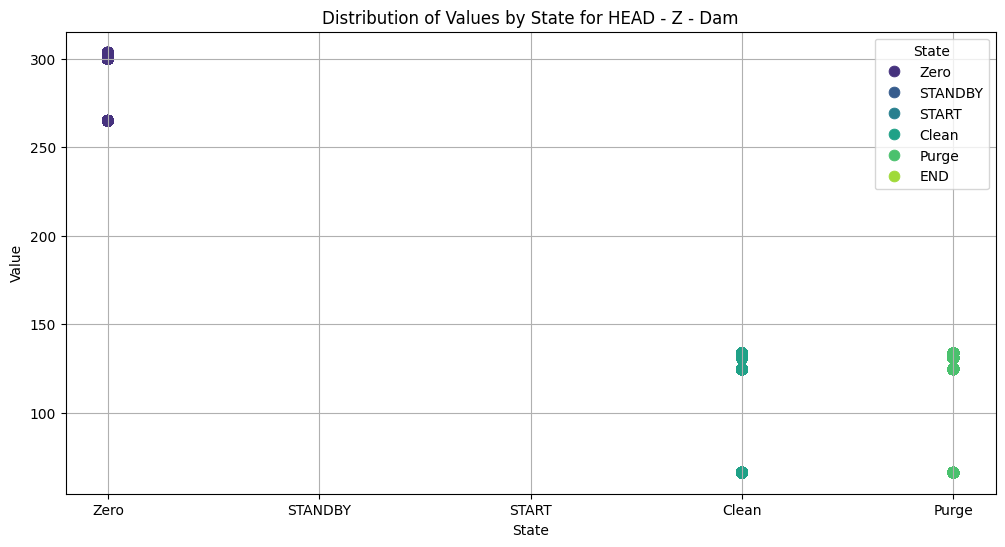

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


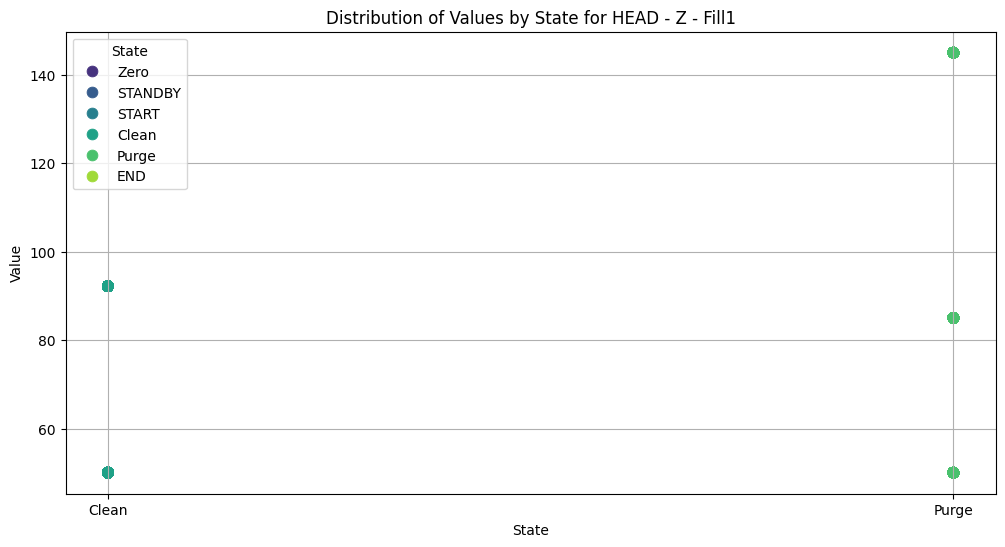

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


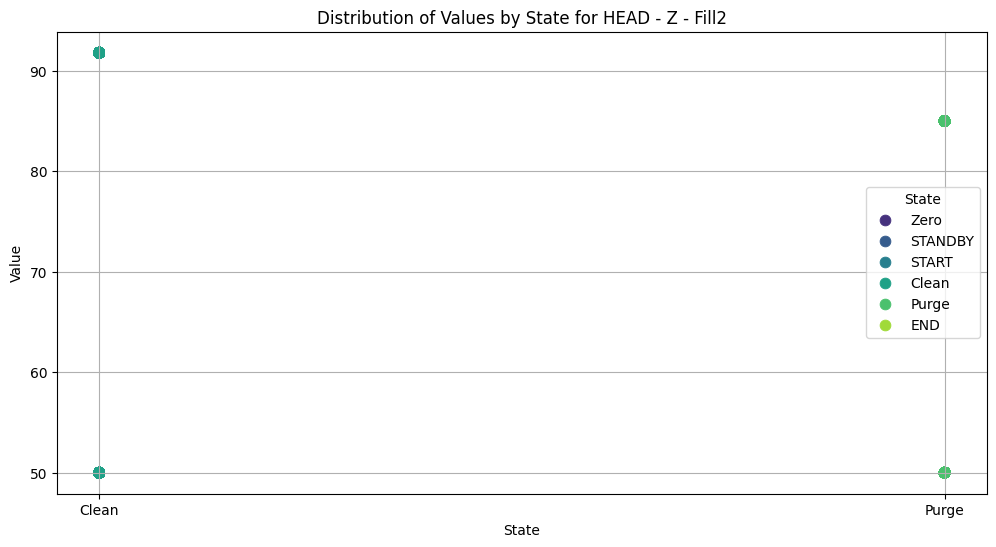

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


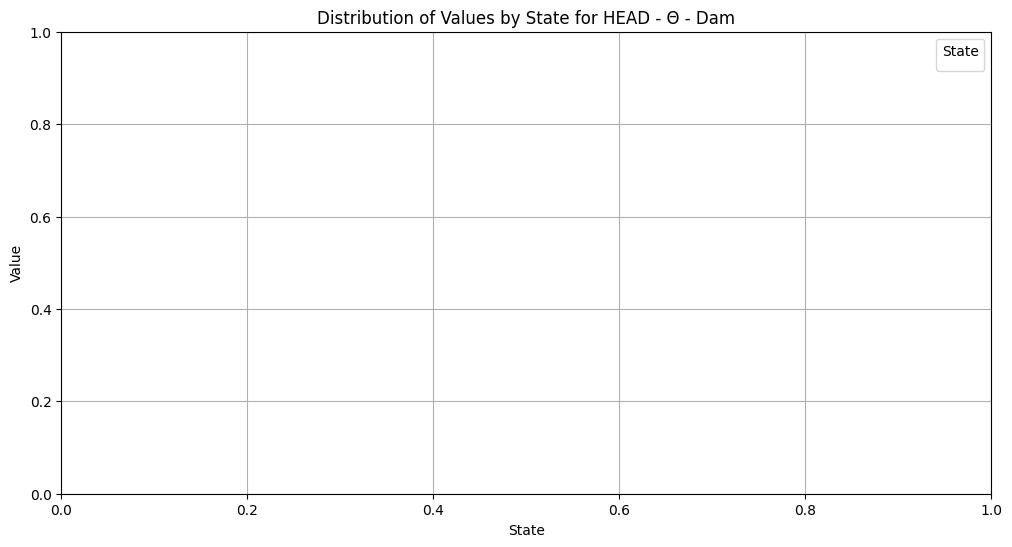

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


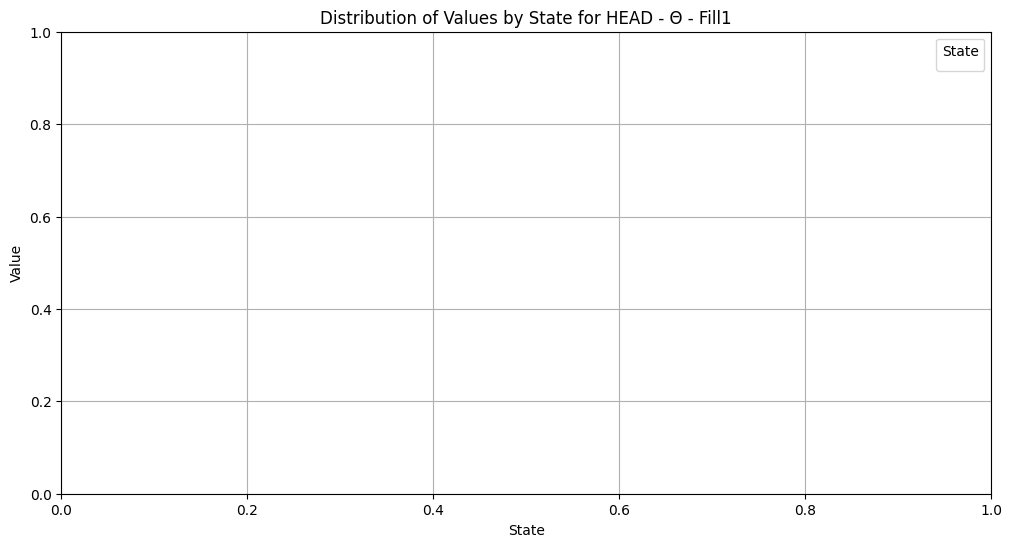

<ipython-input-145-109180d683a4>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)


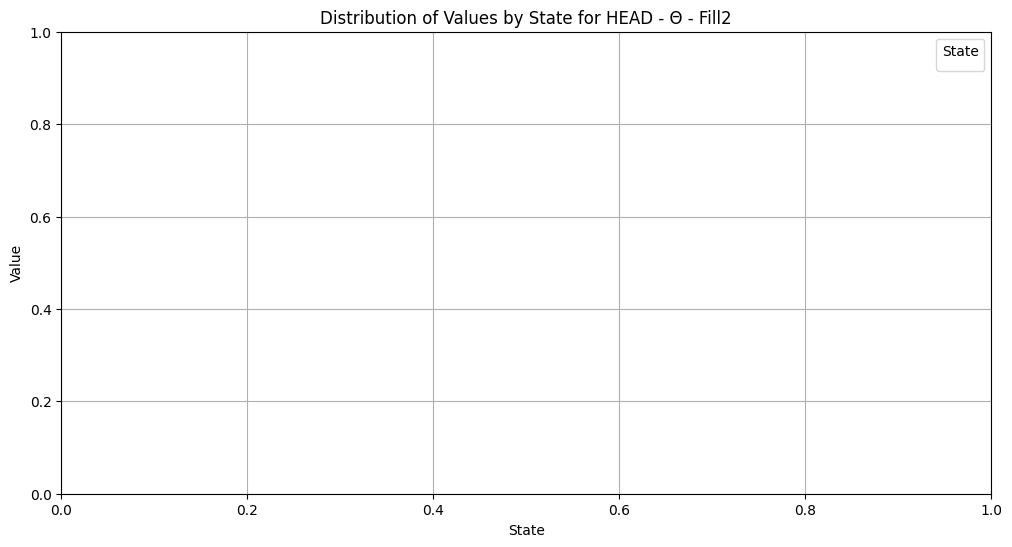

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


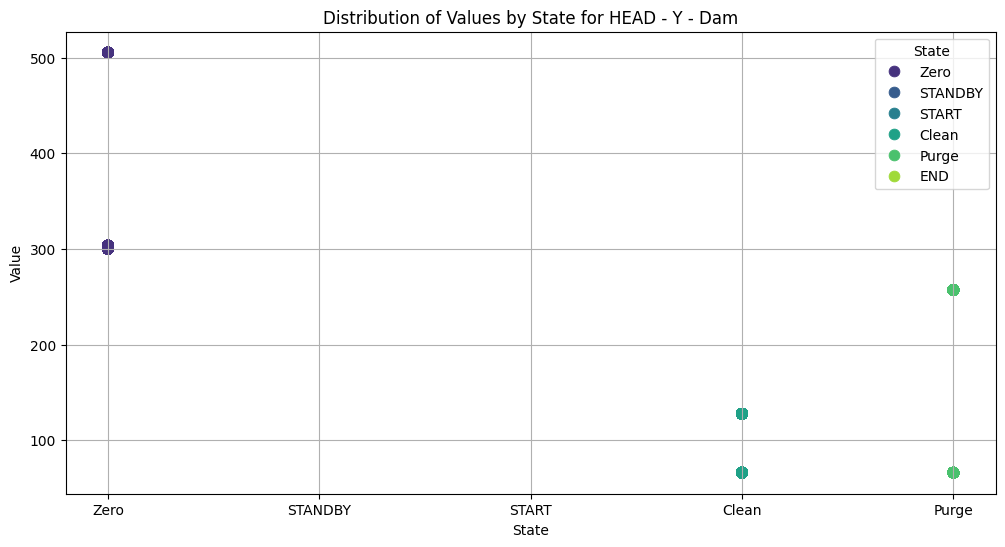

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


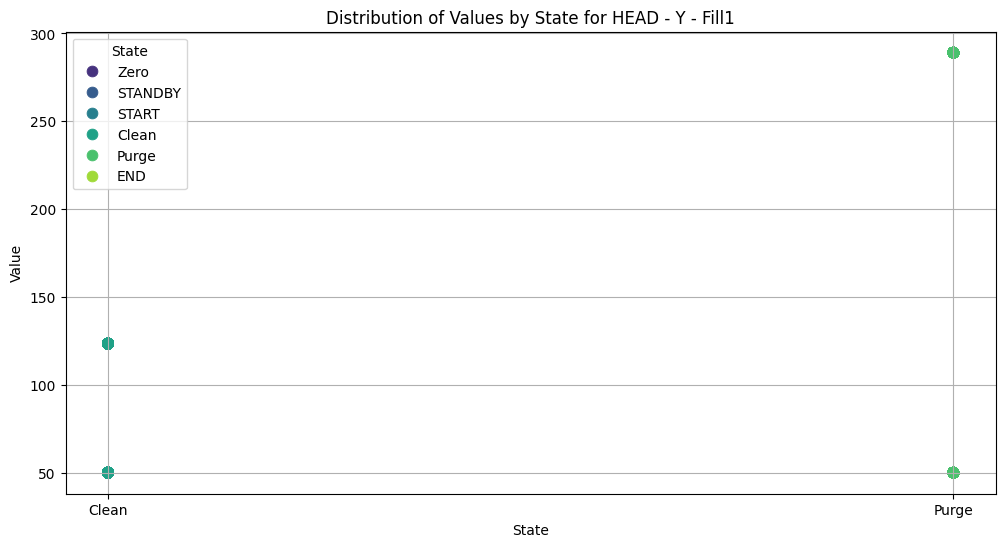

<ipython-input-145-109180d683a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)


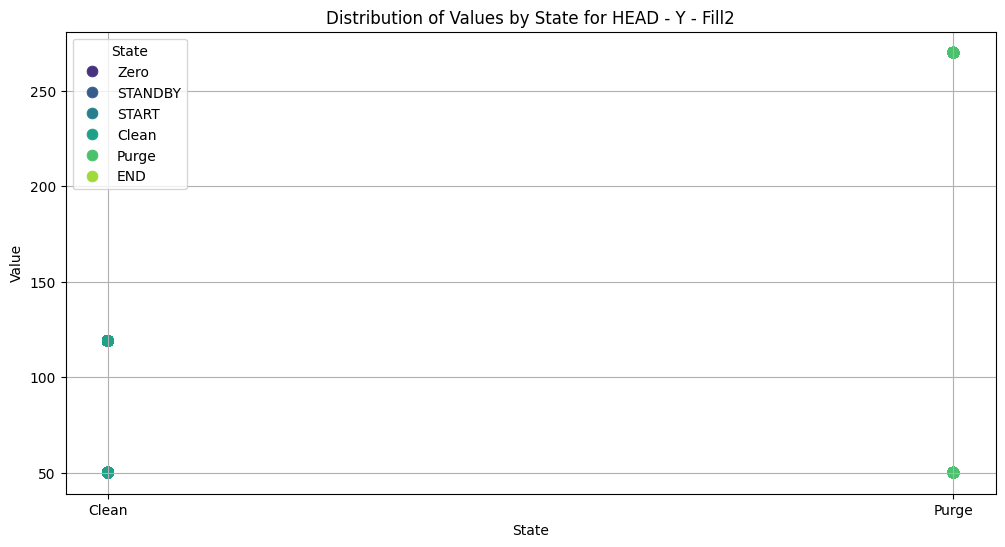

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 상태 순서 정의
state_order = ['Zero', 'STANDBY', 'START', 'Clean', 'Purge', 'END']

# 시각화 함수 정의
def plot_state_value_scatter(df, device, axis, process):
    # 해당 조건에 맞는 데이터 필터링
    df_filtered = df[(df['Device'] == device) &
                     (df['Axis'] == axis) &
                     (df['Process'] == process)]

    plt.figure(figsize=(12, 6))

    # 상태별 색상 구분을 위해 'State'를 범주형 변수로 변환
    df_filtered['State'] = pd.Categorical(df_filtered['State'], categories=state_order, ordered=True)

    # 산점도 생성
    sns.scatterplot(x='State', y='Value', data=df_filtered, hue='State', palette='viridis', s=60, edgecolor=None)

    plt.title(f'Distribution of Values by State for {device} - {axis} - {process}')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend(title='State')
    plt.grid(True)
    plt.show()

# 시각화 예시
devices = df_positions['Device'].unique()
axes = df_positions['Axis'].unique()
processes = df_positions['Process'].unique()

for device in devices:
    for axis in axes:
        for process in processes:
            plot_state_value_scatter(df_positions, device, axis, process)


In [ ]:
POSITION_columns_nnull

['CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE STANDBY POSITION X Collect Result_Dam',
 'CURE STANDBY POSITION Z Collect Result_Dam',
 'CURE STANDBY POSITION Θ Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Z Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'HEAD Standby Position X Collect Result_Dam',
 'HEAD Standby Position Y Collect Result_Dam',
 'HEAD Standby Position Z Collect Result_Dam',
 'Head Clean Position X Collect Result_Dam',
 'Head Clean Position Y Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Head Purge Position X Collect Result_Dam',
 'Head Purge Position Y Collect Result_Dam',
 'Head Purge Position Z Collect Result_Dam',
 'Head Zero Position X Collect Result_Dam',
 'Head Zero Position Y Collect Result_Dam',
 'Head Zero Position Z Collect Result_Dam',
 'HEAD Standby Position X Collect Result_Fill1',
 'H

In [ ]:
df_positions

,Device,State,Axis,Process,Value
0,CURE,END,Unknown,Dam,240.0
1,CURE,END,Unknown,Dam,240.0
2,CURE,END,Unknown,Dam,1000.0
3,CURE,END,Unknown,Dam,1000.0
4,CURE,END,Unknown,Dam,240.0
...,...,...,...,...,...
1944283,HEAD,Purge,Unknown,Fill2,85.0
1944284,HEAD,Purge,Unknown,Fill2,50.0
1944285,HEAD,Purge,Unknown,Fill2,50.0
1944286,HEAD,Purge,Unknown,Fill2,85.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예제 데이터 생성
# df_positions = pd.DataFrame(data) # 이 줄은 이미 df_positions이 만들어졌다고 가정

# 시각화 함수 정의
def plot_device_state_axis_process(df):
    # 유니크한 값 추출
    devices = df['Device'].unique()
    states = df['State'].unique()
    axes = df['Axis'].unique()
    processes = df['Process'].unique()

    # 서브플롯 설정
    num_plots = len(devices) * len(states) * len(axes) * len(processes)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    # 서브플롯마다 데이터 시각화
    plot_index = 0
    for device in devices:
        for state in states:
            for axis in axes:
                for process in processes:
                    df_filtered = df[(df['Device'] == device) &
                                     (df['State'] == state) &
                                     (df['Axis'] == axis) &
                                     (df['Process'] == process)]

                    if df_filtered.empty:
                        continue

                    ax = axes[plot_index]
                    sns.lineplot(data=df_filtered, x='State', y='Value', hue='Process', marker='o', ax=ax)
                    ax.set_title(f'Device: {device}, State: {state}, Axis: {axis}, Process: {process}')
                    ax.set_xlabel('State')
                    ax.set_ylabel('Value')
                    ax.legend(title='Process')
                    ax.grid(True)

                    plot_index += 1
                    if plot_index >= len(axes):
                        break
                if plot_index >= len(axes):
                    break
            if plot_index >= len(axes):
                break
        if plot_index >= len(axes):
            break

    plt.tight_layout()
    plt.show()

# 시각화 실행
plot_device_state_axis_process(df_positions)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79fecb370670> (for post_execute):


KeyboardInterrupt: 

In [ ]:
list_not_null = train_not_null.columns[train_not_null.isna().sum() > 0]
a = train_not_null[list_not_null].columns[train_not_null[list_not_null].nunique() == 1]
a = a.tolist()
train_not_null[a]

,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,OK,OK,OK,OK,OK
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
40501,NaN,NaN,NaN,NaN,NaN
40502,NaN,NaN,NaN,NaN,NaN
40503,OK,OK,OK,OK,OK
40504,NaN,NaN,NaN,NaN,NaN


In [ ]:
COORDINATE_column_nnull

In [ ]:
train_not_null[COORDINATE_column_nnull].select_dtypes(object).isna().sum()

,0
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,29213
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,29213
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2,29213


In [ ]:
len(COORDINATE_columns)

30

In [ ]:
cols2 = train_not_null.columns
unique_cols = []

for i in cols2:
    if train_not_null[i].nunique() == 1:
        unique_cols.append(i)

unique_cols

['Wip Line_Dam',
 'Process Desc._Dam',
 'Insp. Seq No._Dam',
 'Insp Judge Code_Dam',
 'CURE STANDBY POSITION X Collect Result_Dam',
 'CURE STANDBY POSITION Z Collect Result_Dam',
 'CURE STANDBY POSITION Θ Collect Result_Dam',
 'CURE START POSITION Z Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'Wip Line_AutoClave',
 'Process Desc._AutoClave',
 'Equipment_AutoClave',
 'Insp. Seq No._AutoClave',
 'Insp Judge Code_AutoClave',
 '1st Pressure Judge Value_AutoClave',
 '2nd Pressure Judge Value_AutoClave',
 '3rd Pressure Judge Value_AutoClave',
 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
 'Wip Line_Fill1',
 'Process Desc._Fill1',
 'Insp. Seq No._Fill1',
 'Insp Judge Code_Fill1',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
 'Wip Line_Fill2',
 'Process Desc._Fill2',
 'Insp. Seq No._Fill2',
 'Insp Judge Code_Fill2',
 'CURE END POSITION Θ Collect Result_Fill2',
 'CURE STANDBY POSI

In [ ]:
cols2 = train_not_null.columns
unique_cols = []

for i in cols2:
    if train_not_null[i].nunique() == 1:
        unique_cols.append(i)

unique_cols

['Wip Line_Dam',
 'Process Desc._Dam',
 'Insp. Seq No._Dam',
 'Insp Judge Code_Dam',
 'CURE STANDBY POSITION X Collect Result_Dam',
 'CURE STANDBY POSITION Z Collect Result_Dam',
 'CURE STANDBY POSITION Θ Collect Result_Dam',
 'CURE START POSITION Z Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'Wip Line_AutoClave',
 'Process Desc._AutoClave',
 'Equipment_AutoClave',
 'Insp. Seq No._AutoClave',
 'Insp Judge Code_AutoClave',
 '1st Pressure Judge Value_AutoClave',
 '2nd Pressure Judge Value_AutoClave',
 '3rd Pressure Judge Value_AutoClave',
 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
 'Wip Line_Fill1',
 'Process Desc._Fill1',
 'Insp. Seq No._Fill1',
 'Insp Judge Code_Fill1',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
 'Wip Line_Fill2',
 'Process Desc._Fill2',
 'Insp. Seq No._Fill2',
 'Insp Judge Code_Fill2',
 'CURE END POSITION Θ Collect Result_Fill2',
 'CURE STANDBY POSI

In [ ]:
#하나의 값만 가지는 칼럼 제거
cols2 = train_not_null.columns
unique_cols = []

for i in cols2:
    if train_not_null[i].nunique() == 1:
        unique_cols.append(i)

train_final = train_not_null.drop(columns = unique_cols )
print("하나의 값만 가지는 칼럼 제거 후 ",train_final.shape)

하나의 값만 가지는 칼럼 제거 후  (40506, 146)


In [ ]:
train_drop_dup= train_final.copy()

for col in train_drop_dup.columns:
    order = train_drop_dup[col].value_counts().index.tolist()
    order_map = {value: idx for idx, value in enumerate(order)}
    tmp = pd.Categorical(train_drop_dup[col], categories=order, ordered=True)
    train_drop_dup[col] = tmp.codes

list_dup = train_drop_dup.columns[train_drop_dup.T.duplicated(keep=False)]
duplicate_rows = train_drop_dup.T

# 중복된 행들을 찾는 코드
duplicates = duplicate_rows.duplicated(keep=False)

duplicated_df = duplicate_rows[duplicates]

grouped_duplicates = duplicated_df.groupby(list(duplicated_df.columns)).apply(lambda x: list(x.index))

list_check = []
if not grouped_duplicates.empty:
    print("중복된 행들끼리의 인덱스:")
    for group, indices in grouped_duplicates.items():  # iteritems() -> items()
        print(f"중복되는 열: -> 인덱스: {indices} \n")
        list_check.append(indices)
else:
    print("중복된 행이 없습니다.")


중복된 행들끼리의 인덱스:
중복되는 열: -> 인덱스: ['CURE END POSITION X Collect Result_Fill2', 'CURE START POSITION X Collect Result_Fill2'] 

중복되는 열: -> 인덱스: ['CURE STANDBY POSITION Z Collect Result_Fill2', 'CURE START POSITION Z Collect Result_Fill2'] 

중복되는 열: -> 인덱스: ['Equipment_Dam', 'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION X Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam'] 

중복되는 열: -> 인덱스: ['Equipment_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'] 

중복되는 열: -> 인덱스: ['HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Fill1', 'HEAD Standby Posit

In [ ]:
# def are_all_columns_equal(df, columns):
#     """
#     주어진 칼럼 리스트의 모든 칼럼들이 서로 정확히 동일한지 확인합니다.
#     """
#     if not columns:
#         return True

#     first_col = columns[0]

#     for col in columns[1:]:
#         if not df[first_col].equals(df[col]):
#             return False

#     return True

# for i in range(len(list_check)):
#     if are_all_columns_equal(train_final[list_check[i]], list_check[i]) == False:
#         display(train_final[list_check[i]])
#         print(train_final[list_check[i]].nunique())

In [ ]:
train_drop_dup = train_drop_dup.T.drop_duplicates().T
cols_drop_dup = train_drop_dup.columns

train_final = train_final[cols_drop_dup]
print("인코딩 중복 제거 후 : ",train_final.shape)

a= train_final.isnull().sum() > 0
a= a.index
null_list = a[train_final.isnull().sum() > 0]

#null 칼럼 세개 제거
train_final = train_final.drop(columns=null_list)
print("null 칼럼 제거 후 : ",train_final.shape)

인코딩 중복 제거 후 :  (40506, 96)
null 칼럼 제거 후 :  (40506, 93)


In [ ]:
# 지금까지 칼럼을 전처리 하는 방법은 끝이고 이제 각 데이터 칼럼 값을 바꾸는 과정을 진행할 예정으로 train,test 모두 처리해주어야한다.

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/LG Aimers/test.csv")
test_data = test_data[train_final.columns]
test_data.shape

(17361, 93)

In [ ]:
# cols = cols.to_list()
# cols_Dam = []
# cols_AutoClave = []
# cols_Fill1 = []
# cols_Fill2 = []

# for col in cols[:]:
#     if col.endswith('_Dam'):
#         cols_Dam.append(col)
#         cols.remove(col)
#     elif col.endswith('_AutoClave'):
#         cols_AutoClave.append(col)
#         cols.remove(col)
#     elif col.endswith('_Fill1'):
#         cols_Fill1.append(col)
#         cols.remove(col)
#     elif col.endswith('_Fill2'):
#         cols_Fill2.append(col)
#         cols.remove(col)

# # 결과 확인
# print(f"cols_Dam:{len(cols_Dam)}\n", cols_Dam)
# print(f"cols_AutoClave:{len(cols_AutoClave)}\n", cols_AutoClave)
# print(f"cols_Fill1:{len(cols_Fill1)}\n", cols_Fill1)
# print(f"cols_Fill2:{len(cols_Fill2)}\n", cols_Fill2)
# print(f"Remaining cols:{len(cols)}\n", cols)


cols_Dam:46
 ['Model.Suffix_Dam', 'Workorder_Dam', 'CURE SPEED Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage2) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'HEAD Standby Position X Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam', 'Head Purge Position X Collect Result_Dam', 'Head Purge

In [ ]:
train_bins = train_final.copy()
test_bins = test_data.copy()

In [ ]:
Time_columns = [col for col in train_final.columns if 'Time' in col]

train_bins[Time_columns[0]] = train_final[Time_columns[0]] / train_final[Time_columns[3]]
train_bins[Time_columns[1]] = train_final[Time_columns[1]] / train_final[Time_columns[3]]
train_bins[Time_columns[2]] = train_final[Time_columns[2]] / train_final[Time_columns[3]]

test_bins[Time_columns[0]] = test_data[Time_columns[0]] / test_data[Time_columns[3]]
test_bins[Time_columns[1]] = test_data[Time_columns[1]] / test_data[Time_columns[3]]
test_bins[Time_columns[2]] = test_data[Time_columns[2]] / test_data[Time_columns[3]]

In [ ]:
time_columns = list(set([col for col in train_final.columns if 'time' in col.lower()]) - set(Time_columns))
train_final[time_columns].nunique()

,0
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,24
Machine Tact time Collect Result_Dam,266
Machine Tact time Collect Result_Fill1,194
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,16
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,16
Machine Tact time Collect Result_Fill2,42
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,20
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,29
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,19


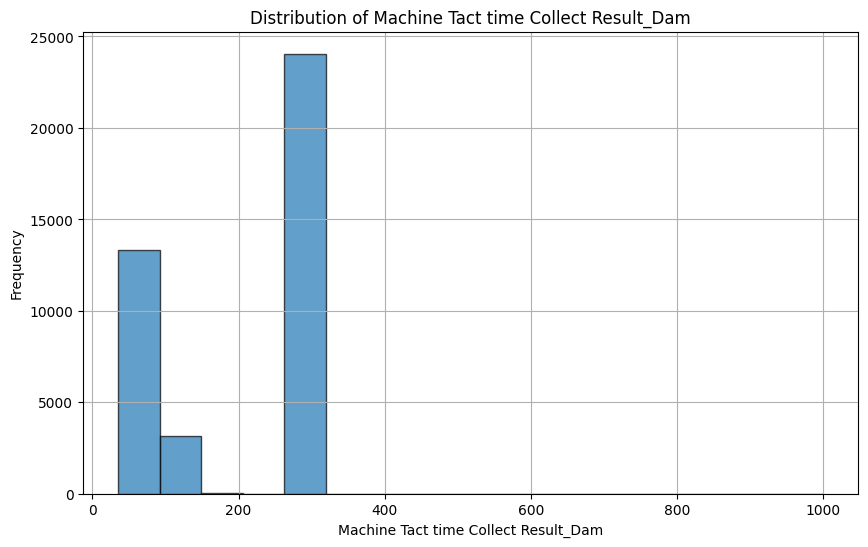

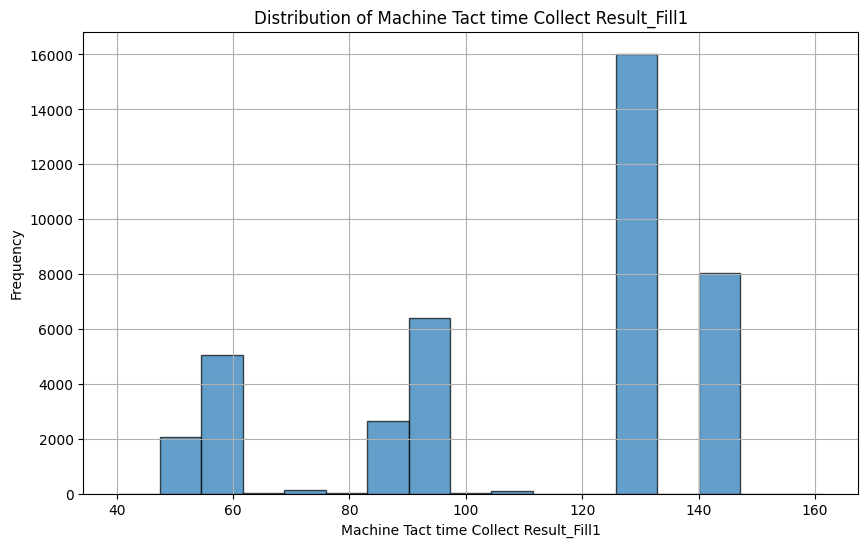

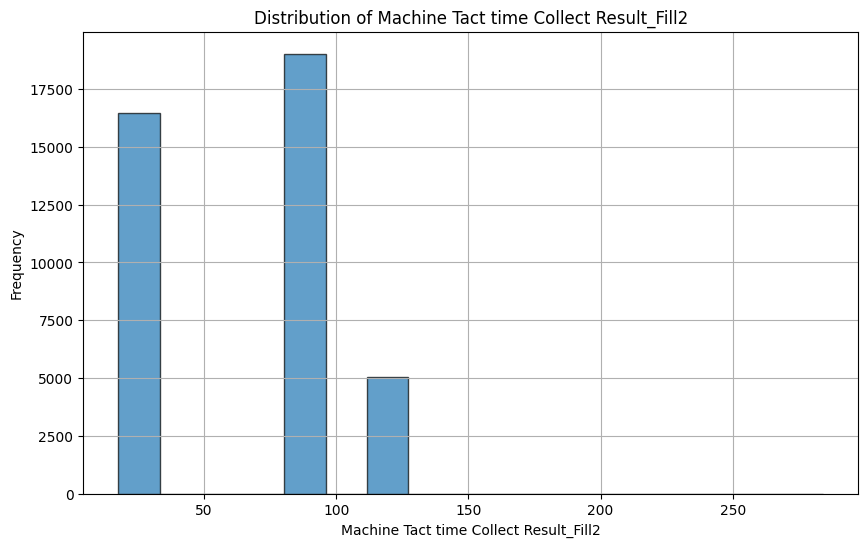

In [ ]:
# #Machine_Tact_time 은 구간화가 필요함


# for col in Machine_Tact_time_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(train_final[col], bins='sturges', alpha=0.7, edgecolor='black')  # 'sturges' 규칙 사용
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(f'{col}')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

In [ ]:
# 'Machine Tact time'이 포함된 열 이름 리스트 생성
Machine_Tact_time_columns = [col for col in train_final.columns if 'Machine Tact time' in col]

for col in Machine_Tact_time_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)

    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [ ]:
train_bins[Machine_Tact_time_columns].isna().sum()

,0
Machine Tact time Collect Result_Dam,0
Machine Tact time Collect Result_Fill1,0
Machine Tact time Collect Result_Fill2,0


In [ ]:
#Pallet 칼럼들 전처리 (3개의 칼럼)
Pallet_columns = [col for col in train_final.columns if 'pallet' in col.lower()]

#Qty 칼럼들 전처리 (3개의 칼럼)
Qty_columns = [col for col in train_final.columns if 'qty' in col.lower()]

#Receip 칼럼들 전처리 (3개의 칼럼)
Receip_columns = [col for col in train_final.columns if 'receip' in col.lower()]
train_final[Receip_columns]

print("Pallet_columns:" ,len(Pallet_columns))
print("Qty_columns:" ,len(Qty_columns))
print("Receip_columns:" ,len(Receip_columns))
# 총 9개의 칼럼은 중요도가 높아 잘 학습할 수 있도록 처리해야함

Pallet_columns: 3
Qty_columns: 3
Receip_columns: 3


In [ ]:
# #Pallet_ID ID의 의미라면 구간화는 진행하지 않고 카테고리로 변환해야할듯
for col in Pallet_columns:
    train_bins[col] = train_bins[col].astype('category')
# for col in Pallet_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(train_final[col], bins='sturges', alpha=0.7, edgecolor='black')  # 'sturges' 규칙 사용
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(f'{col}')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

# for col in Qty_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(train_final[col], bins='sturges', alpha=0.7, edgecolor='black')  # 'sturges' 규칙 사용
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(f'{col}')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

# for col in Receip_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(train_final[col], bins='sturges', alpha=0.7, edgecolor='black')  # 'sturges' 규칙 사용
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(f'{col}')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

COORDINATE_columns: 18


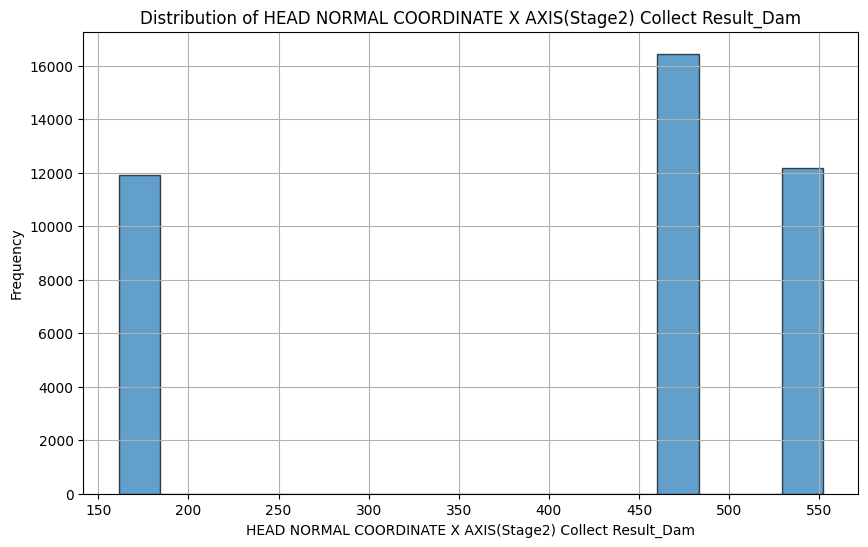

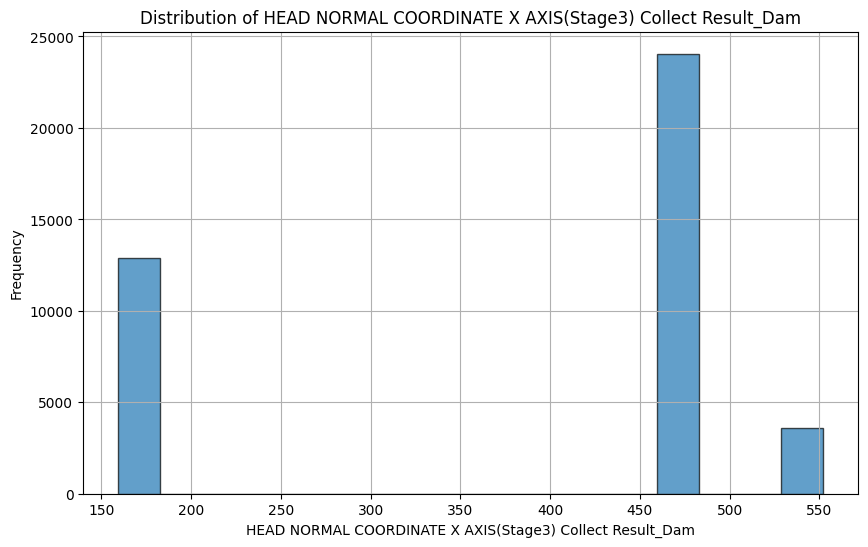

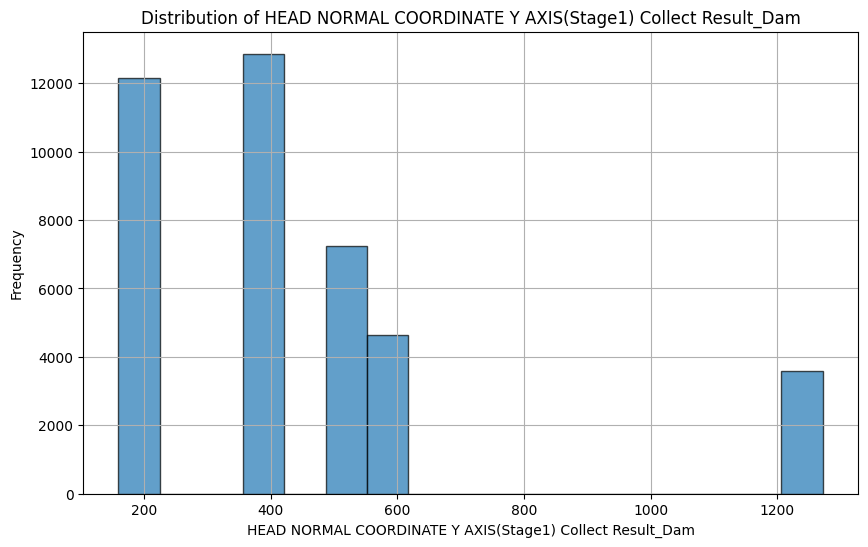

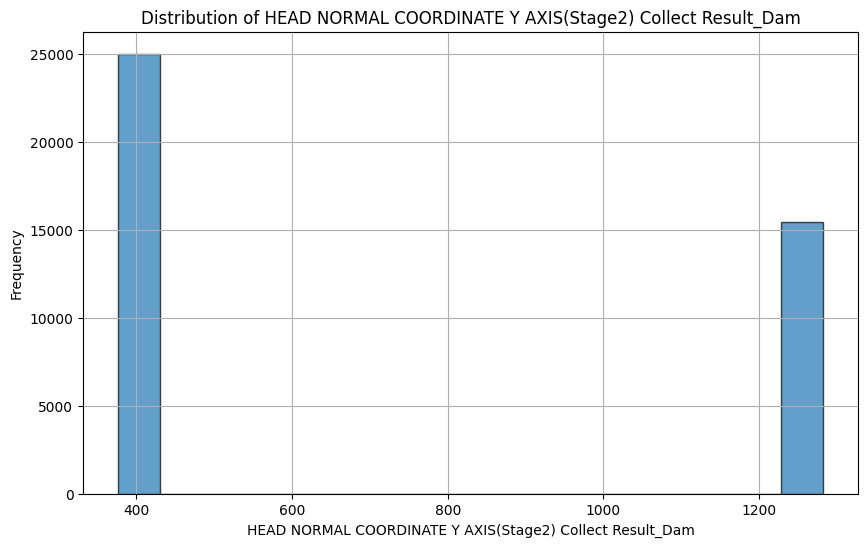

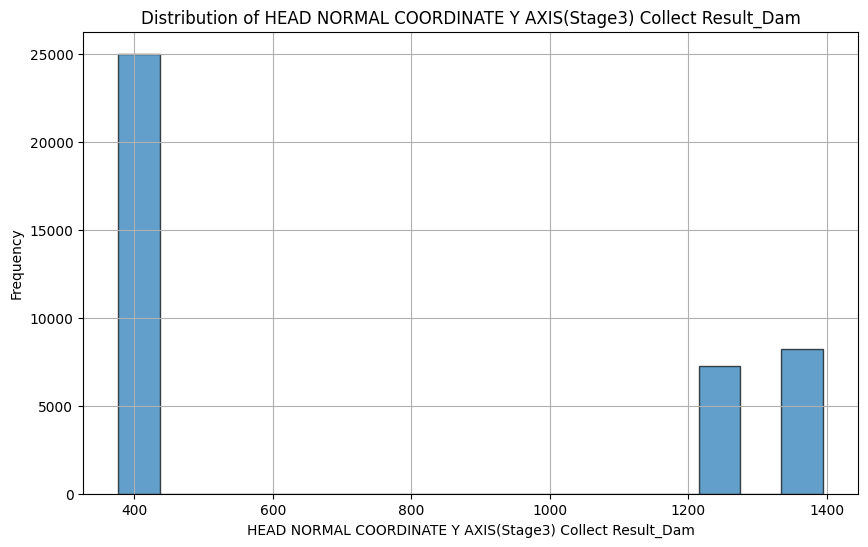

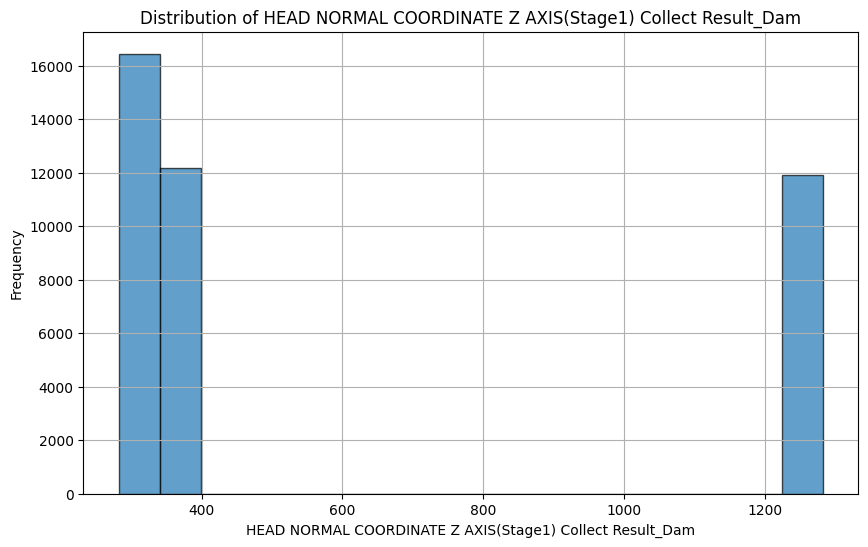

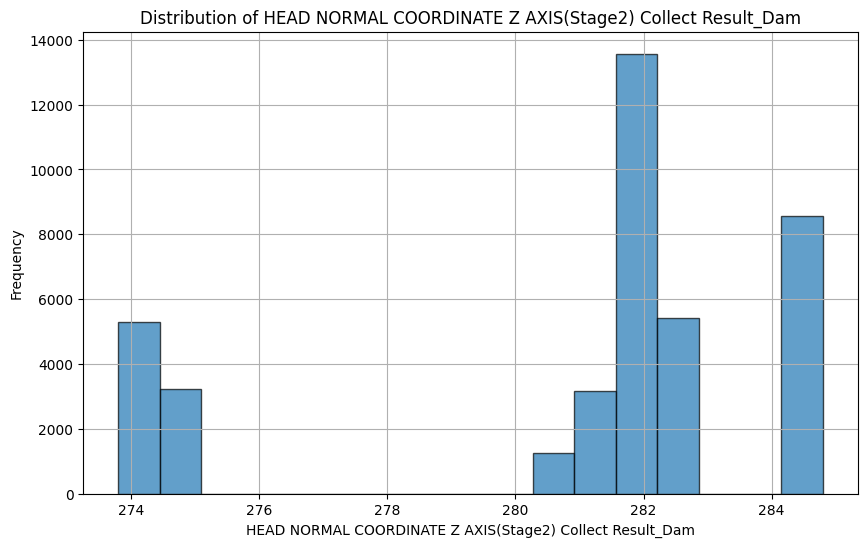

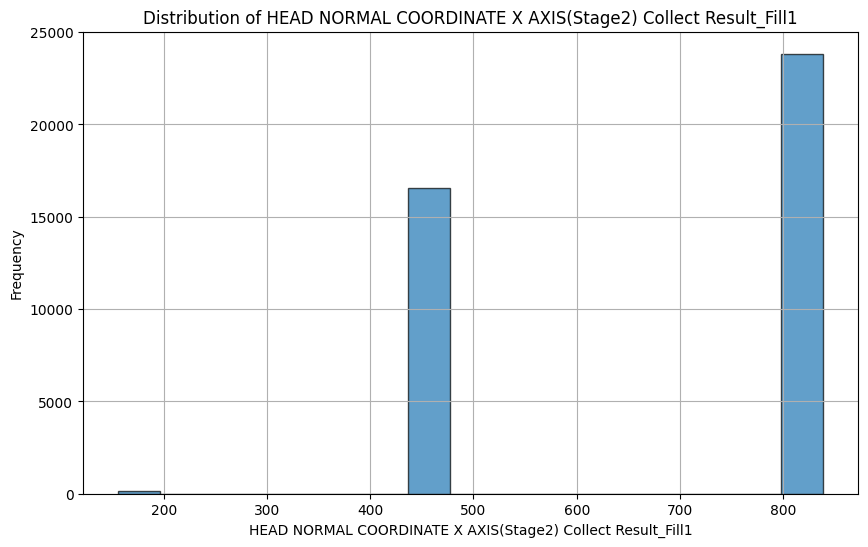

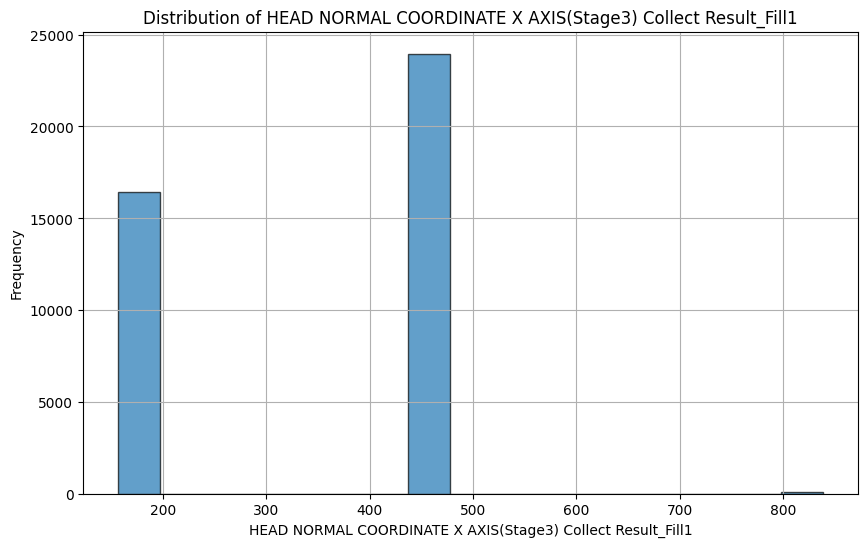

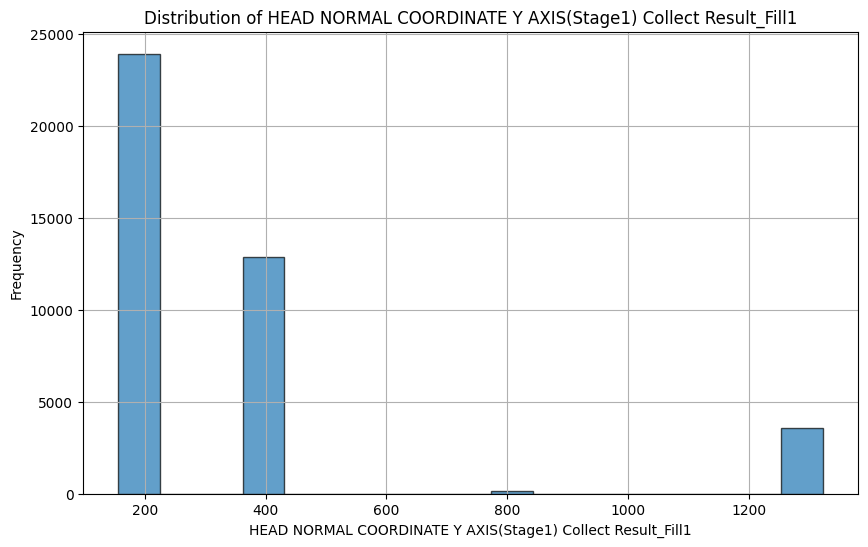

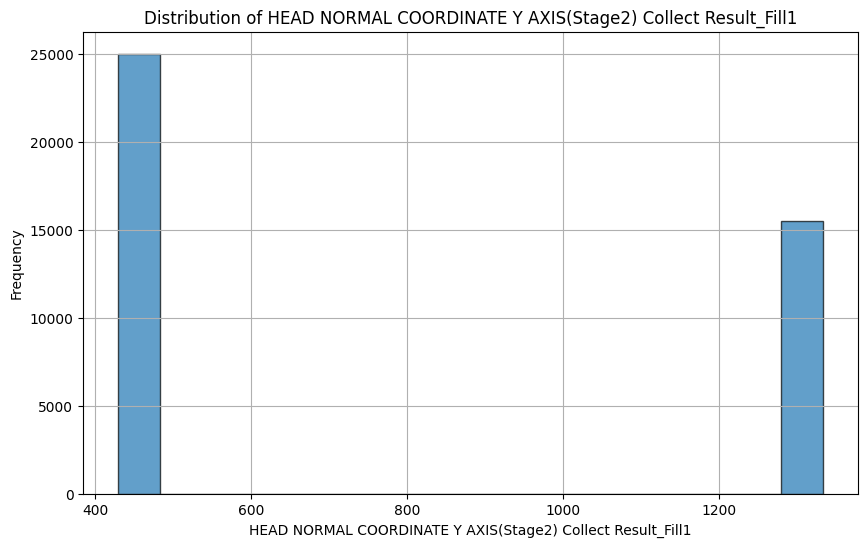

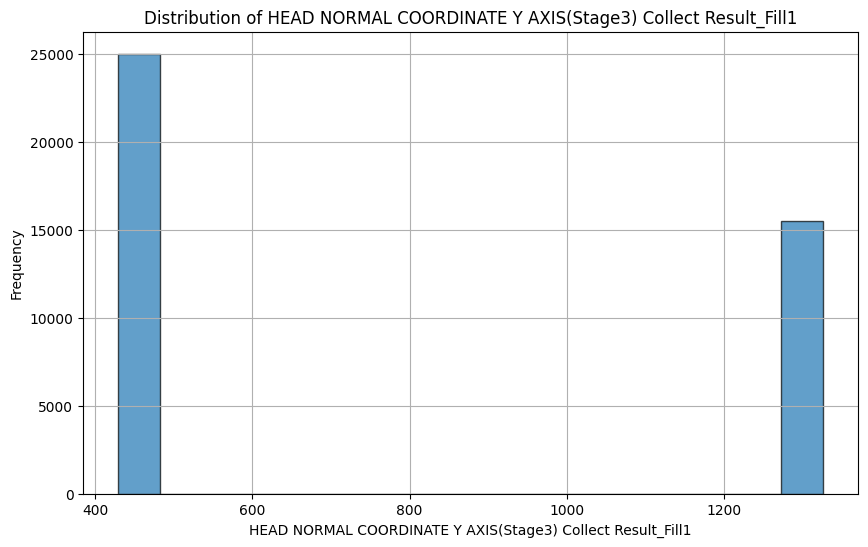

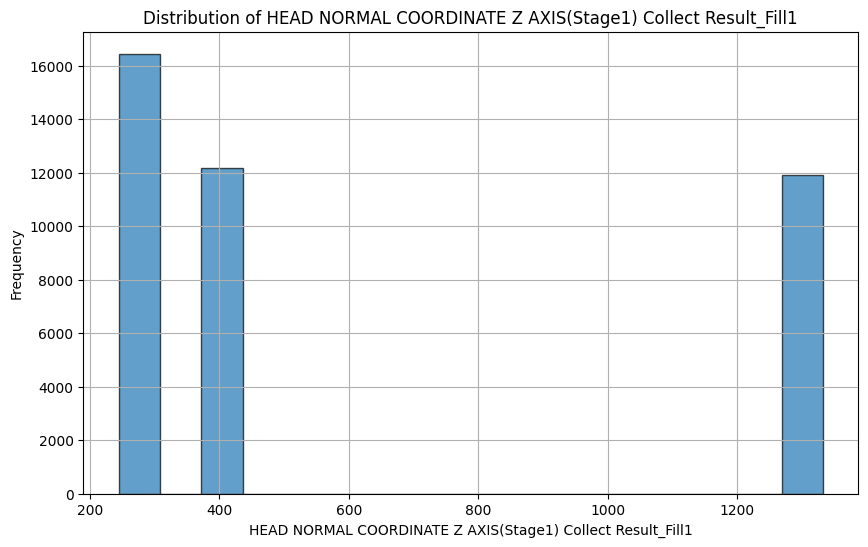

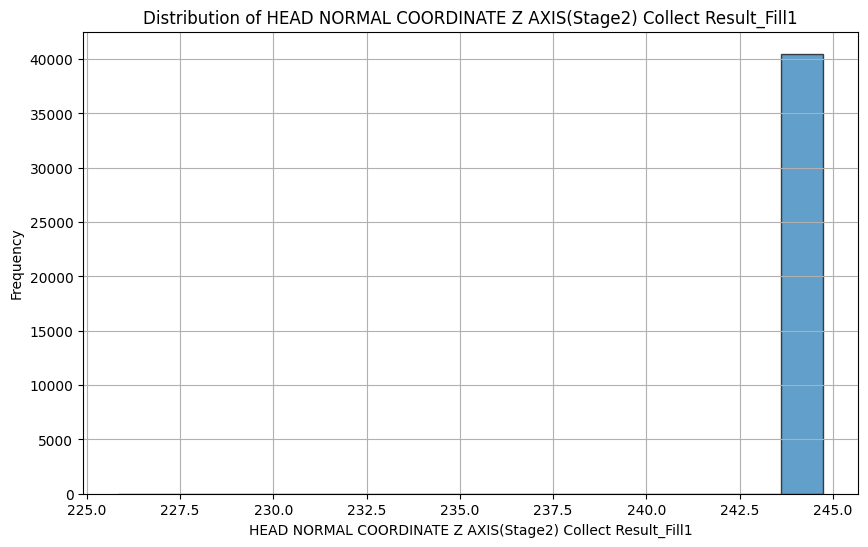

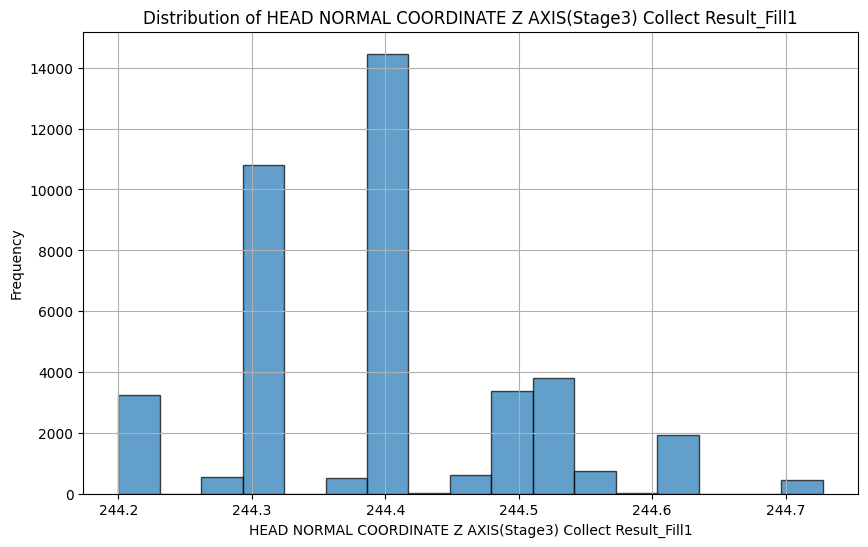

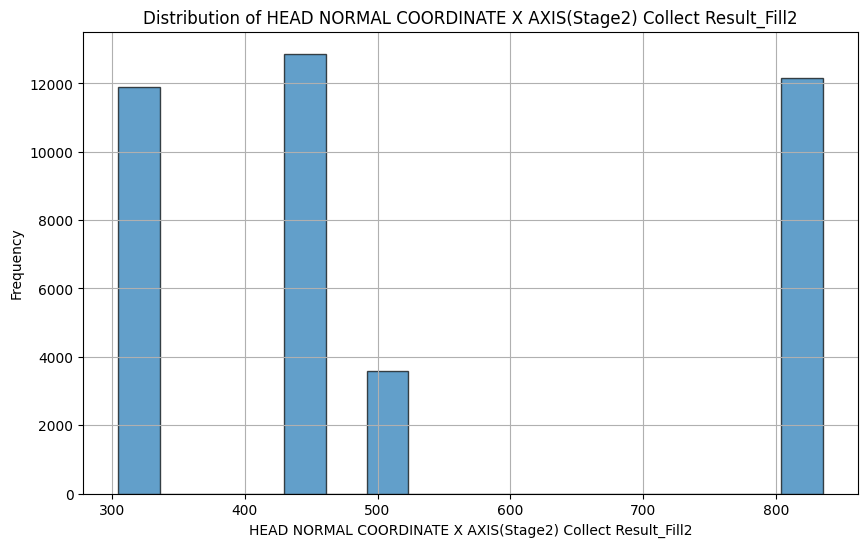

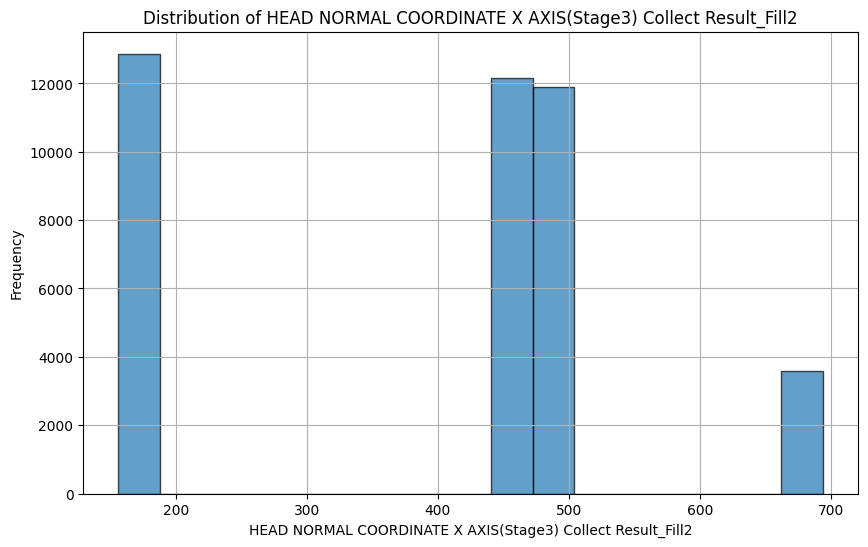

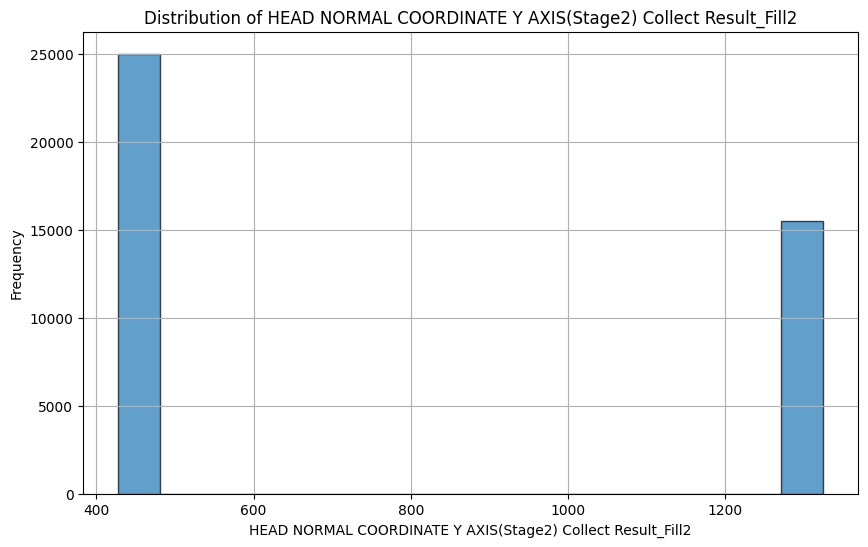

POSITION_columns: 13


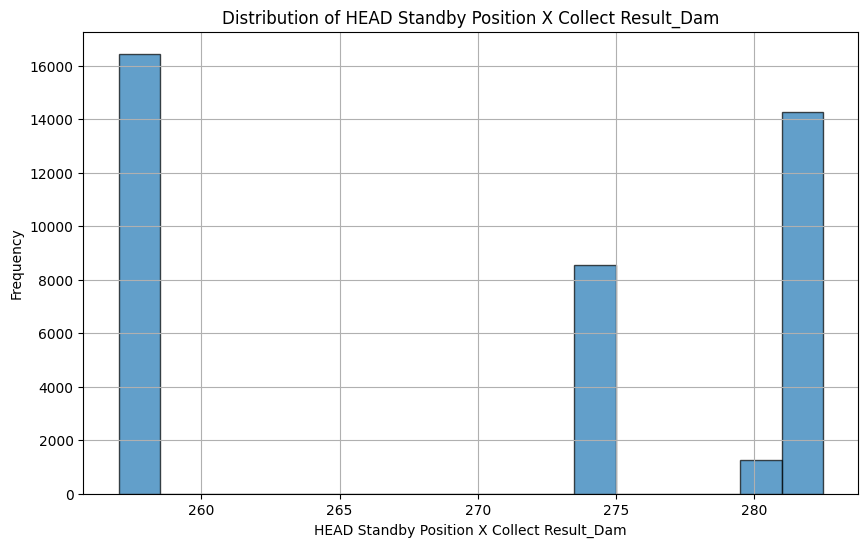

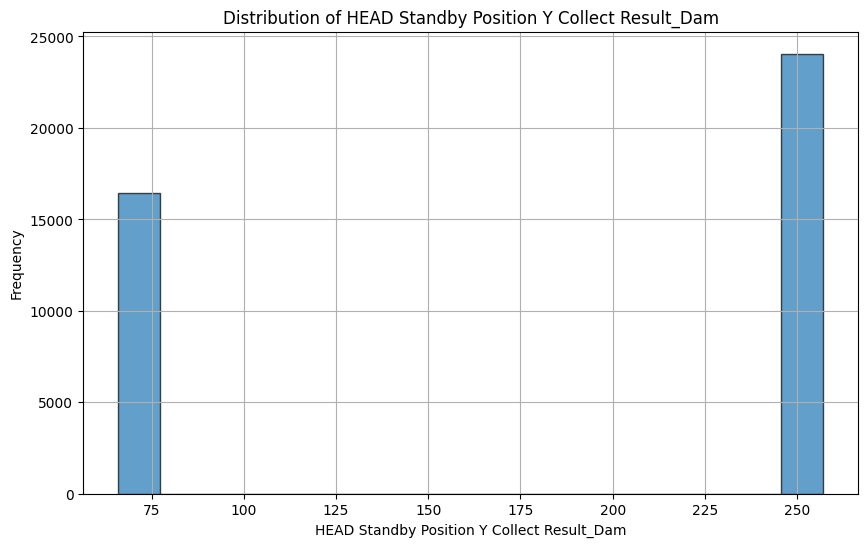

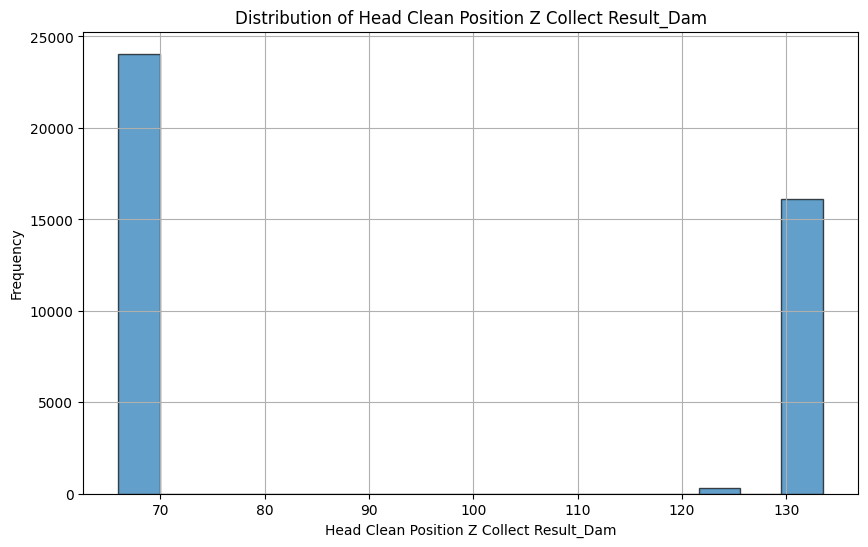

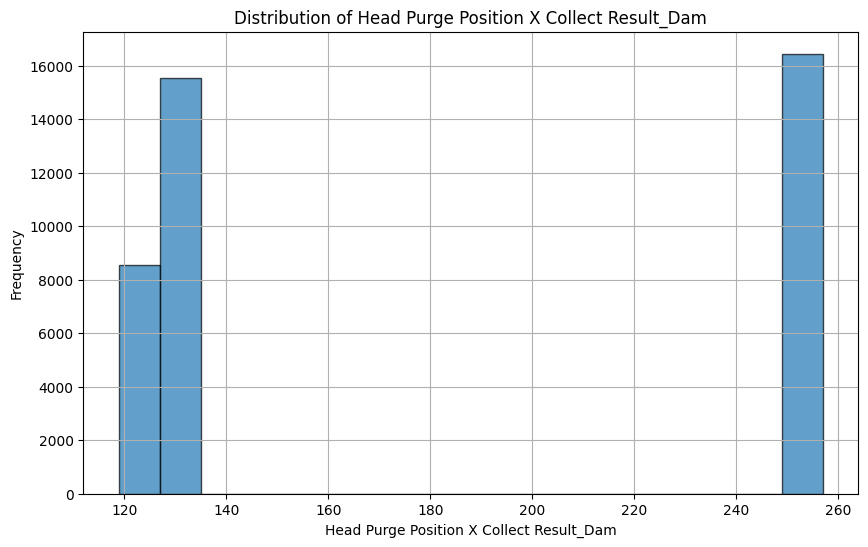

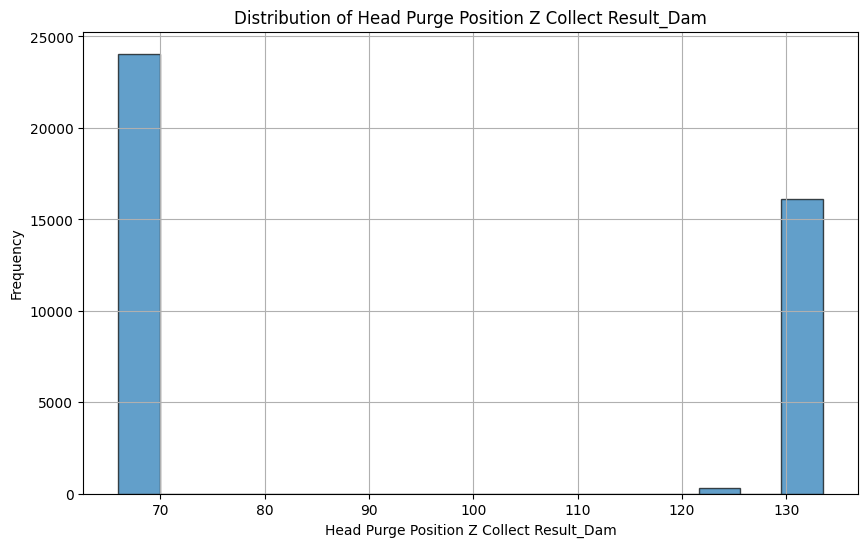

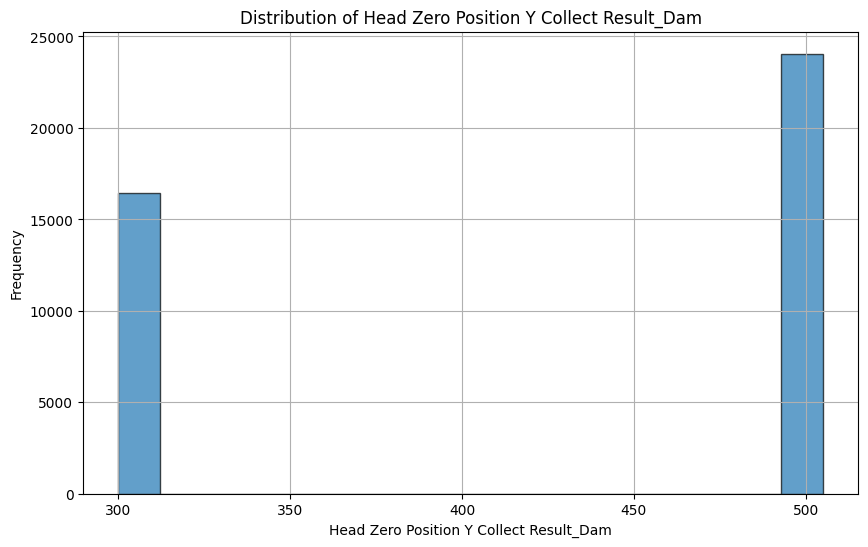

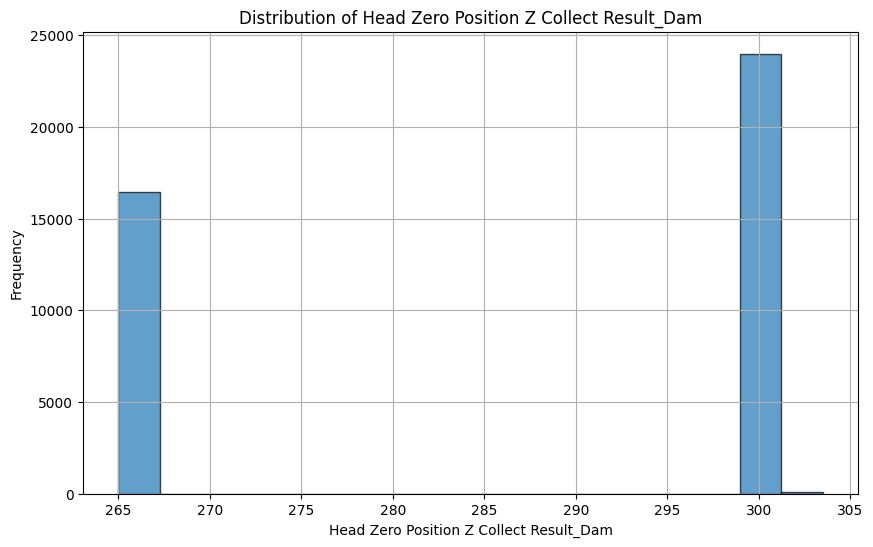

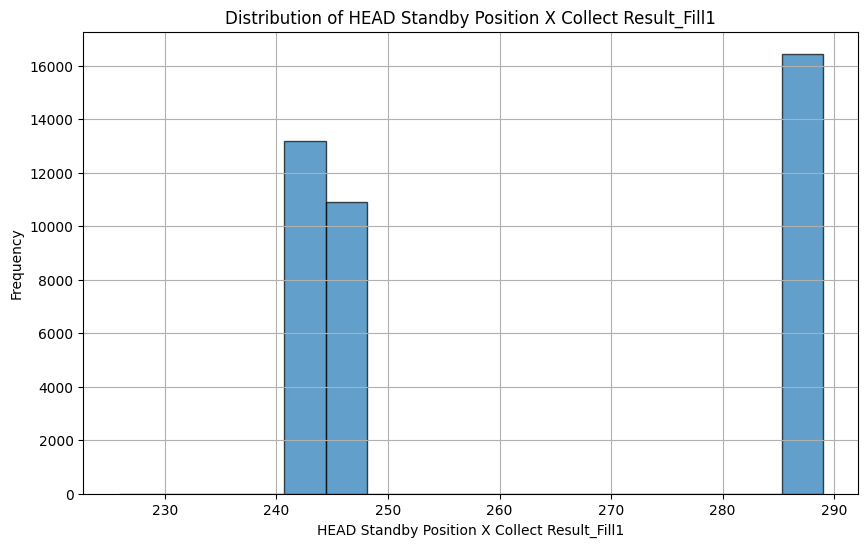

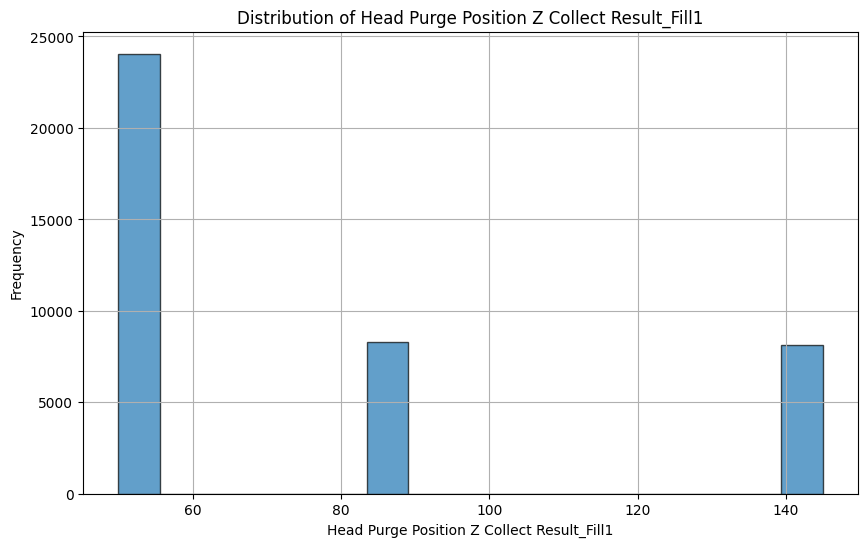

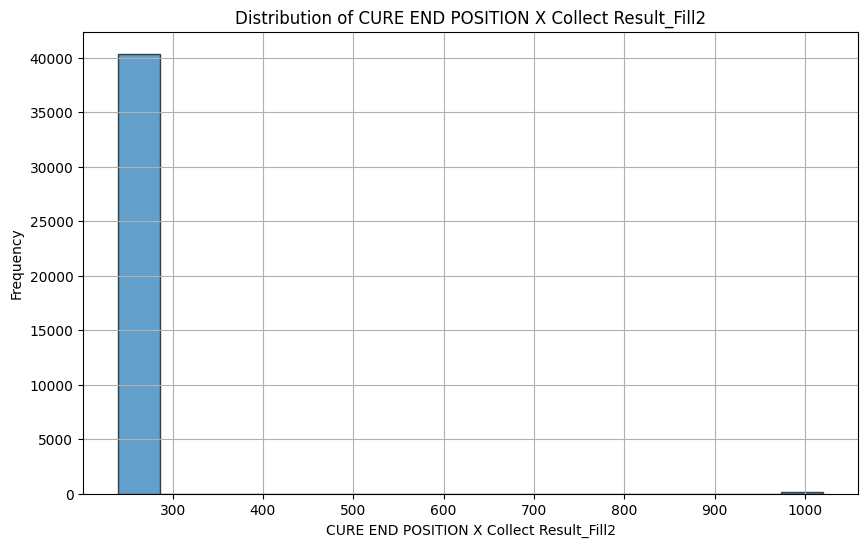

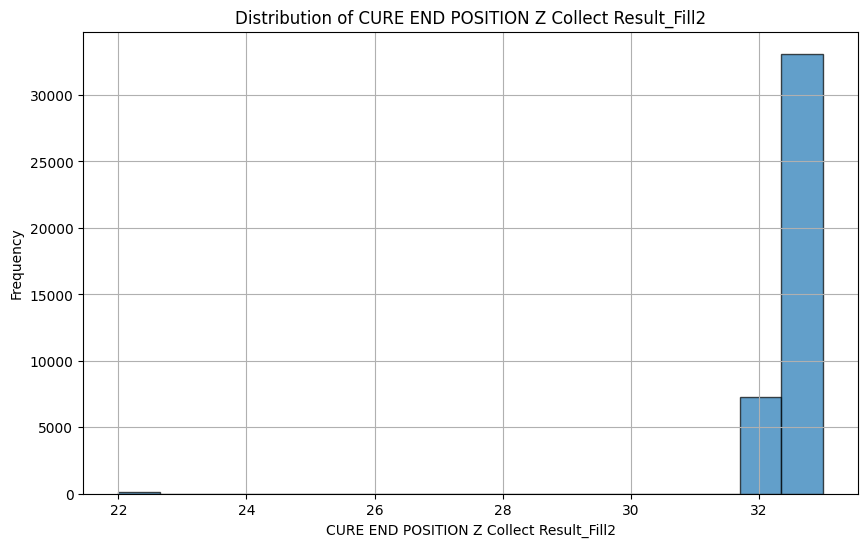

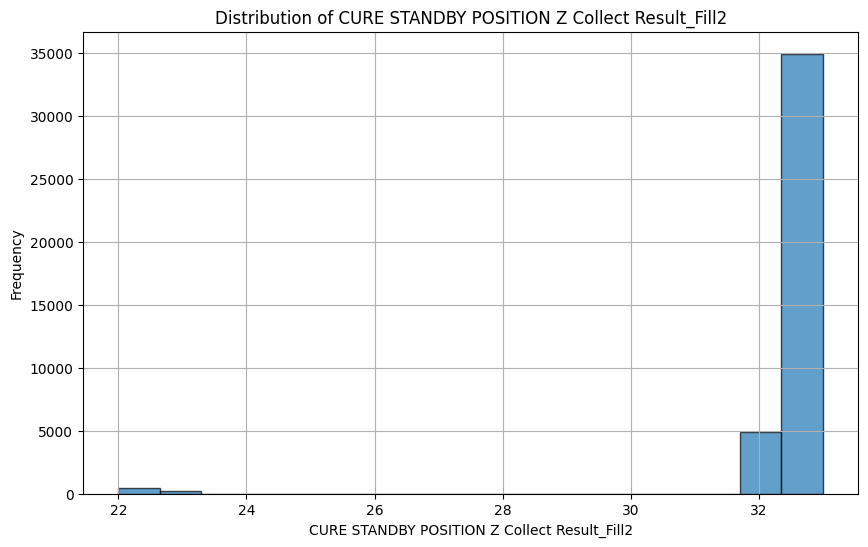

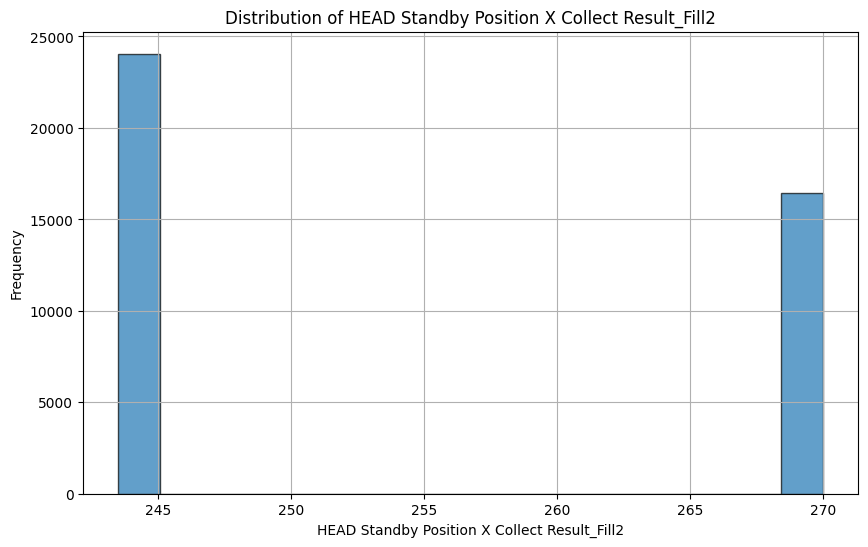

In [ ]:
# #COORDINATE 칼럼들 전처리 (18개의 칼럼)
# COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]
# print("COORDINATE_columns:" ,len(COORDINATE_columns))

# for col in COORDINATE_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(train_final[col], bins='sturges', alpha=0.7, edgecolor='black')  # 'sturges' 규칙 사용
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(f'{col}')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()
# #POSITION  칼럼들 전처리 (13개의 칼럼)
# POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]
# print("POSITION_columns:" ,len(POSITION_columns))

# for col in POSITION_columns:
#     plt.figure(figsize=(10, 6))
#     plt.hist(train_final[col], bins='sturges', alpha=0.7, edgecolor='black')  # 'sturges' 규칙 사용
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(f'{col}')
#     plt.ylabel('Frequency')
#     plt.grid(True)

In [ ]:
#COORDINATE_columns를 구간화

COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]

for col in COORDINATE_columns:
    combined_data = pd.concat([train_final[col], test_data[col]])

    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)

    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

In [ ]:
#POSITION_columns 을 구간화

POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]

for col in POSITION_columns:
    combined_data = pd.concat([train_final[col], test_data[col]])

    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)

    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

In [ ]:
COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]
POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]

In [ ]:
integration_columns = time_columns+Pallet_columns+Qty_columns+Receip_columns+COORDINATE_columns+POSITION_columns
remain_columns= list(set(train_final.columns.tolist()) - set(integration_columns))

print("지금까지의 칼럼을 제외한 칼럼",len(remain_columns))

train_remain =train_final[remain_columns]

지금까지의 칼럼을 제외한 칼럼 44


In [ ]:
Dispense_Volume_columns = [col for col in train_remain.columns if 'Dispense Volume' in col]
print("Dispense_Volume_columns의 개수" ,len(Dispense_Volume_columns))

Distance_Speed_columns = [col for col in train_remain.columns if 'Distance Speed' in col]
print("Distance_Speed_columns 개수" ,len(Distance_Speed_columns))

DISCHARGED_SPEED_columns = [col for col in train_remain.columns if 'DISCHARGED SPEED' in col]
print("DISCHARGED_SPEED_columns 개수" ,len(DISCHARGED_SPEED_columns))

THICKNESS_columns = [col for col in train_remain.columns if 'THICKNESS' in col]
print("THICKNESS_columns 개수" ,len(THICKNESS_columns))

Pressure_columns= [col for col in train_remain.columns if 'Pressure' in col]
print("Pressure_columns 개수" ,len(Pressure_columns))

WorkMode_columns= [col for col in train_remain.columns if 'WorkMode' in col]
print("WorkMode_columns 개수" ,len(WorkMode_columns))

CURE_SPEED_columns= [col for col in train_remain.columns if 'CURE SPEED' in col]
print("CURE_SPEED_columns 개수" ,len(CURE_SPEED_columns))

list_binary = train_remain.columns[train_remain.nunique() ==2].tolist()
print("list_binary 개수" ,len(list_binary))

q= Dispense_Volume_columns + Distance_Speed_columns + DISCHARGED_SPEED_columns+THICKNESS_columns+Pressure_columns +WorkMode_columns+CURE_SPEED_columns +list_binary


train_remain2 = train_remain[list(set(train_remain.columns) - set(q))]
train_remain2.nunique()

Dispense_Volume_columns의 개수 4
Distance_Speed_columns 개수 15
DISCHARGED_SPEED_columns 개수 2
THICKNESS_columns 개수 3
Pressure_columns 개수 6
WorkMode_columns 개수 3
CURE_SPEED_columns 개수 2
list_binary 개수 5


,0
Chamber Temp. Collect Result_AutoClave,26
Workorder_Dam,663
Model.Suffix_Dam,7
Chamber Temp. Unit Time_AutoClave,24


In [ ]:
# 이 순서로 처리하면 겹치는 칼럼이 없음을 확인

print("칼럼의 길이의 총 합: ",len(Dispense_Volume_columns) +len(Distance_Speed_columns) +len(DISCHARGED_SPEED_columns) +len(THICKNESS_columns) +len(Pressure_columns) +len(WorkMode_columns) +len(CURE_SPEED_columns) +len(list_binary))
print("train_remain 의 칼럼개수 - train_remain2의 칼럼개수 ",train_remain.shape[1] - train_remain2.shape[1])

if (len(Dispense_Volume_columns) +len(Distance_Speed_columns) +len(DISCHARGED_SPEED_columns) +len(THICKNESS_columns) +len(Pressure_columns) +len(WorkMode_columns) +len(CURE_SPEED_columns) +len(list_binary)) == train_remain.shape[1] - train_remain2.shape[1]:
  print("겹치는 칼럼이 없음을 확인")


칼럼의 길이의 총 합:  40
train_remain 의 칼럼개수 - train_remain2의 칼럼개수  40
겹치는 칼럼이 없음을 확인


In [ ]:
# 값이 두개인 경우 먼저 True/ False 로 처리
list_binary.remove('target')
for col in list_binary:
    most_frequent_value = train_bins[col].mode()[0]  # 가장 빈도가 높은 값

    train_bins[col] = train_bins[col] == most_frequent_value
    train_bins[col] = train_bins[col].astype(bool)

    test_bins[col] = test_bins[col] == most_frequent_value
    test_bins[col] = test_bins[col].astype(bool)

test_bins.drop('target',axis=1, inplace=True)

In [ ]:
display(train_bins.head())
display(test_bins.head())

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,True,AJX75334505,4F1XA938-1,100,16,14.9,8.4,14.7,1.04,0.58,...,835.5,458.0,428.0,243.7,119.497059,19.9,7,127,1,Normal
1,True,AJX75334505,3KPM0016-2,70,10,21.3,4.9,21.3,1.49,0.34,...,458.0,156.0,427.9,270.0,25.438235,7.0,185,1,0,Normal
2,False,AJX75334501,4E1X9167-1,85,16,14.7,8.5,14.7,1.61,0.93,...,305.0,499.8,1324.2,243.5,119.497059,19.8,10,73,1,Normal
3,False,AJX75334501,3K1X0057-1,70,10,21.3,8.4,21.3,1.49,0.58,...,499.8,694.0,1324.2,270.0,25.438235,12.0,268,1,0,Normal
4,True,AJX75334501,3HPM0007-1,70,10,9.7,4.9,9.6,0.67,0.34,...,458.0,156.0,427.9,270.0,25.438235,8.0,121,1,0,Normal


,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,CURE STANDBY POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,False,AJX75334501,3J1XF767-1,70,10,17.0,4.9,17.0,1.19,0.34,...,33,499.8,694.0,1324.2,270.0,25.438235,13.0,195,1,0
1,False,AJX75334501,4B1XD472-2,70,16,14.2,8.3,14.2,0.99,0.58,...,33,305.0,499.8,1324.2,243.5,88.144118,19.8,14,256,1
2,True,AJX75334501,3H1XE355-1,70,10,9.7,4.9,9.7,0.67,0.34,...,23,458.0,156.0,427.9,270.0,25.438235,1.0,98,1,0
3,False,AJX75334501,3L1XA128-1,70,10,21.3,10.6,21.3,1.49,0.74,...,33,305.0,499.8,1324.2,243.5,88.144118,20.0,14,0,1
4,True,AJX75334501,4A1XA639-1,70,16,13.2,7.5,13.2,0.92,0.52,...,33,835.5,458.0,428.0,243.7,88.144118,19.8,1,215,1


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.feature_selection import SelectFromModel

In [ ]:
train_bins['target'] = train_final['target']
train_pre = train_bins
test_pre = test_bins

In [ ]:
train_pre['target'] = train_pre['target'].map({'Normal': 1, 'AbNormal': 0})

cols_target_encoding = train_pre.select_dtypes(include=['category', 'object','bool']).columns.tolist()
cols_standard_encoding = train_pre.select_dtypes(include=['int', 'float']).columns.tolist()
cols_standard_encoding.remove('target')

if (len(train_pre.columns) -1 == len(cols_standard_encoding) + len(cols_target_encoding)):
  print("모든 칼럼이 인코딩 예정입니다")

target_enc = ce.TargetEncoder(cols=cols_target_encoding)
train_data_encoded = target_enc.fit_transform(train_pre[cols_target_encoding], train_pre['target'])
test_data_encoded = target_enc.transform(test_pre[cols_target_encoding])

모든 칼럼이 인코딩 예정입니다


In [ ]:
display(train_pre.head(3))
display(test_pre.head(3))

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,True,AJX75334505,4F1XA938-1,100,16,14.9,8.4,14.7,1.04,0.58,...,835.5,458.0,428.0,243.7,119.497059,19.9,7,127,1,1
1,True,AJX75334505,3KPM0016-2,70,10,21.3,4.9,21.3,1.49,0.34,...,458.0,156.0,427.9,270.0,25.438235,7.0,185,1,0,1
2,False,AJX75334501,4E1X9167-1,85,16,14.7,8.5,14.7,1.61,0.93,...,305.0,499.8,1324.2,243.5,119.497059,19.8,10,73,1,1


,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,CURE STANDBY POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,False,AJX75334501,3J1XF767-1,70,10,17.0,4.9,17.0,1.19,0.34,...,33,499.8,694.0,1324.2,270.0,25.438235,13.0,195,1,0
1,False,AJX75334501,4B1XD472-2,70,16,14.2,8.3,14.2,0.99,0.58,...,33,305.0,499.8,1324.2,243.5,88.144118,19.8,14,256,1
2,True,AJX75334501,3H1XE355-1,70,10,9.7,4.9,9.7,0.67,0.34,...,23,458.0,156.0,427.9,270.0,25.438235,1.0,98,1,0


In [ ]:
from sklearn.preprocessing import StandardScaler

model = StandardScaler()

for col in cols_standard_encoding:
    train_data_encoded[col] = model.fit_transform(train_pre[[col]])
    test_data_encoded[col] = model.transform(test_pre[[col]])

In [ ]:
train_data_encoded['target'] = train_final['target']
train_data_encoded['target'] = train_data_encoded['target'].map({'Normal': 1, 'AbNormal': 0})

In [ ]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = train_data_encoded[train_data_encoded["target"] == 1] # Normal
df_abnormal = train_data_encoded[train_data_encoded["target"] == 0] # AbNormal

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


,count
target,
0,2350
1,2350


In [ ]:
# 데이터 분할
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.25, # 0.25 일때가 최고 성능 보임 (0.2, 0.24, 0.26, 0.27, 0.3, 0.35)
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == 1])
    num_abnormal = len(df[df["target"] == 0])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1763, AbNormal: 1762 ratio: 0.9994327850255247
  Total: Normal: 587, AbNormal: 588 ratio: 1.0017035775127767


In [ ]:
# 1. Feature와 Target 분리
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

In [ ]:
100*sum(y_train==0)/(sum(y_train==1)+sum(y_train==0))

49.98581560283688

In [ ]:
100*sum(y_val==0)/(sum(y_val==1)+sum(y_val==0))

50.04255319148936

### 3. 피쳐 중요도 시각화 및 중요도에 따른 가중치 부여

### 3.1 SHAP Value 평가

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import xgboost as xgb

RANDOM_STATE = 110

In [ ]:
# 모델 학습 (예: XGBoost)
model = xgb.XGBClassifier(random_state=RANDOM_STATE,enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=110, ...)

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
import shap
from sklearn.preprocessing import StandardScaler

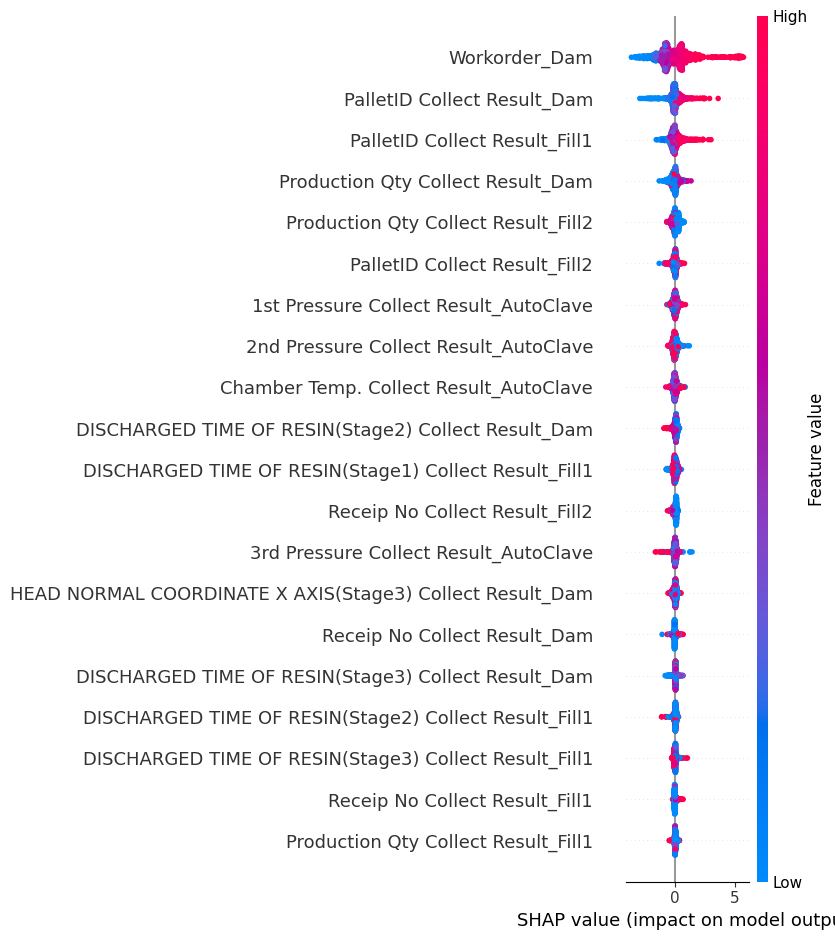

In [ ]:
# SHAP 값 계산을 위한 explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# SHAP 값 시각화 (각 피처의 중요도)
shap.summary_plot(shap_values, X_val)

### 3.3 SHAP 결과 분석

1. 세로축의 feature:
- 세로축에 나열된 피처들은 모델의 예측에 대한 중요도에 따라 정렬됨.
- 상단에 있는 피처일수록 모델의 예측에 큰 영향을 미쳤음을 의미한다.

2. SHAP 값 (가로축):
- SHAP 값은 각 피처가 모델의 예측에 기여한 정도를 나타냄.
- 0보다 큰 값은 해당 피처가 예측 값을 증가시키는 방향으로 영향을 미쳤음을 의미하고,
- 0보다 작은 값은 예측 값을 감소시키는 방향으로 영향을 미쳤음을 의미합니다.
- 예를 들어, Workorder_Dam의 SHAP 값이 오른쪽으로 크게 나타나는 경우, 이 피처의 높은 값이 예측 값을 증가시키는 데 기여했음을 의미한다.

3. 색상:
- 색상은 각 피처의 값 크기를 나타낸다. 일반적으로 파란색은 낮은 값을, 빨간색은 높은 값을 나타냅니다.
- 예를 들어, Receip No Collect Result_Fill1에서 빨간색 점들이 주로 오른쪽에 위치한다면, 이 피처의 높은 값이 예측을 증가시키는 방향으로 기여했음을 의미한다.

4. 주요 피처 분석
- **Workorder_Dam:**
모델에 가장 큰 영향을 미친 피처입니다. 이 피처의 값이 높을수록 (빨간색), 모델의 예측 값도 증가하는 경향이 있습니다.

- **Receip No Collect Result_Fill1:**
이 피처는 두 번째로 중요한 피처로, SHAP 값의 분포가 넓게 퍼져 있습니다. 이는 이 피처가 다양한 범위의 예측 결과에 기여하고 있음을 나타냅니다.

- **PalletID Collect Result_Dam:**
이 피처도 모델 예측에 상당한 영향을 미치고 있습니다. 색상과 SHAP 값의 분포를 보면, 값이 낮을 때 (파란색) 예측을 감소시키는 경향이 있습니다.
결론

SHAP 값으로 중요도를 분석하고 가중치를 적용하기 위해서
- scaling
- standardization을 적용할 수 있다. -> 표준화를 사용하기 위해서는 원핫인코딩을 사용하는 것이 좋다.

### 중요도를 기반으로 피쳐 선택
- SHAP값의 절댓값의 평균을 구하여 중요도를 평가한다.
- 한 피쳐의 여러개의 값은 예측마다 다를 수 있기 때문에
- 한 피쳐내 모든 값의 절댓값의 평균을 이용해서 그 피쳐를 대표한다.

중요도는 피처가 모델 예측에 미치는 영향력을 의미하며, 값의 크기와는 무관하다.
SHAP 값은 피처의 중요도를 측정하는 도구로, 피처 값의 크기가 아닌, 그 피처가 예측에 얼마나 기여했는지를 기반으로 중요도를 평가함.

- 따라서 모델의 성능을 최적화하기 위해서는 피처의 절대적인 값의 크기보다는, 피처의 예측 기여도(중요도)를 평가하는 것이 중요.

In [ ]:
# 5. SHAP 중요도를 기반으로 피처 선택
# SHAP 값의 절대값 평균을 구하여 중요도를 평가ㅏ
shap_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

In [ ]:
# 중요 피처 기준 설정 (예: 상위 20개 피처만 선택)
threshold = 70
important_features = shap_importance['feature'].head(threshold).tolist()

In [ ]:
# 중요 피처만을 선택하여 새로운 데이터셋 생성
X_train_selected = X_train[important_features]
X_val_selected = X_val[important_features]

## 모델 학습 및 평가

여기서 하이퍼 파라미터는 GPU 돌려서 가장 잘 나오는 하이퍼파리미터로 선정했다.

0823_Leem_GPU 참조
* 이후 모델 성능 높인후 마지막에 한번 더 최적의 성능을 만드는 하이퍼파라미터 골라야함


In [ ]:
# 선택된 피처로 모델 재학습
model_selected = xgb.XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=1,
    subsample=0.8,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    enable_categorical=True
)
model_selected.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=110, ...)

### 검증데이터로 평가

In [ ]:
# 8. 검증 데이터셋으로 기존 모델 평가 인코딩 변화 후 # 좌표, position 구간화 X
y_pred_original = model.predict(X_val)
accuracy_original = accuracy_score(y_val, y_pred_original)
report_original = classification_report(y_val, y_pred_original)
print(f"Validation Accuracy (Original): {accuracy_original:.2f}")
print("Classification Report (Original):")
print(report_original)

Validation Accuracy (Original): 0.64
Classification Report (Original):
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       588
           1       0.65      0.61      0.63       587

    accuracy                           0.64      1175
   macro avg       0.64      0.64      0.64      1175
weighted avg       0.64      0.64      0.64      1175



In [ ]:
# 8. 검증 데이터셋으로 기존 모델 평가 인코딩 변화 후 # 좌표, position 구간화 X
y_pred_original = model.predict(X_val)
accuracy_original = accuracy_score(y_val, y_pred_original)
report_original = classification_report(y_val, y_pred_original)
print(f"Validation Accuracy (Original): {accuracy_original:.2f}")
print("Classification Report (Original):")
print(report_original)

Validation Accuracy (Original): 0.64
Classification Report (Original):
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       588
           1       0.65      0.61      0.63       587

    accuracy                           0.64      1175
   macro avg       0.64      0.64      0.64      1175
weighted avg       0.64      0.64      0.64      1175



In [ ]:
# 피처 선택 후 모델 평가
y_pred_selected = model_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val, y_pred_selected)
report_selected = classification_report(y_val, y_pred_selected)
print(f"Validation Accuracy (Selected Features): {accuracy_selected:.2f}")
print("Classification Report (Selected Features):")
print(report_selected)

Validation Accuracy (Selected Features): 0.67
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       588
           1       0.69      0.63      0.66       587

    accuracy                           0.67      1175
   macro avg       0.68      0.67      0.67      1175
weighted avg       0.68      0.67      0.67      1175



In [ ]:
# # 피처 선택 후 모델 평가 #20
# y_pred_selected = model_selected.predict(X_val_selected)
# accuracy_selected = accuracy_score(y_val, y_pred_selected)
# report_selected = classification_report(y_val, y_pred_selected)
# print(f"Validation Accuracy (Selected Features): {accuracy_selected:.2f}")
# print("Classification Report (Selected Features):")
# print(report_selected)

Validation Accuracy (Selected Features): 0.68
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.67      0.72      0.70       588
           1       0.70      0.65      0.67       587

    accuracy                           0.68      1175
   macro avg       0.69      0.68      0.68      1175
weighted avg       0.69      0.68      0.68      1175



In [ ]:
# # 피처 선택 후 모델 평가 # 70
# y_pred_selected = model_selected.predict(X_val_selected)
# accuracy_selected = accuracy_score(y_val, y_pred_selected)
# report_selected = classification_report(y_val, y_pred_selected)
# print(f"Validation Accuracy (Selected Features): {accuracy_selected:.2f}")
# print("Classification Report (Selected Features):")
# print(report_selected)

Validation Accuracy (Selected Features): 0.68
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       588
           1       0.69      0.64      0.66       587

    accuracy                           0.68      1175
   macro avg       0.68      0.68      0.68      1175
weighted avg       0.68      0.68      0.68      1175



In [ ]:
# 피처 선택 후 모델 평가 # 70 # Coordinate , position 구간화 X
y_pred_selected = model_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val, y_pred_selected)
report_selected = classification_report(y_val, y_pred_selected)
print(f"Validation Accuracy (Selected Features): {accuracy_selected:.2f}")
print("Classification Report (Selected Features):")
print(report_selected)

# 좌표, posision의 구간화는 별 의미가 없는거 같음 다른 방법을 찾아봐야할듯

Validation Accuracy (Selected Features): 0.67
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       588
           1       0.69      0.63      0.66       587

    accuracy                           0.67      1175
   macro avg       0.68      0.67      0.67      1175
weighted avg       0.68      0.67      0.67      1175



In [ ]:
# # 피처 선택 후 모델 평가 # 60
# y_pred_selected = model_selected.predict(X_val_selected)
# accuracy_selected = accuracy_score(y_val, y_pred_selected)
# report_selected = classification_report(y_val, y_pred_selected)
# print(f"Validation Accuracy (Selected Features): {accuracy_selected:.2f}")
# print("Classification Report (Selected Features):")
# print(report_selected)

Validation Accuracy (Selected Features): 0.68
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.66      0.71      0.69       588
           1       0.69      0.64      0.66       587

    accuracy                           0.68      1175
   macro avg       0.68      0.68      0.68      1175
weighted avg       0.68      0.68      0.68      1175



In [ ]:
# # 피처 선택 후 모델 평가 # 80
# y_pred_selected = model_selected.predict(X_val_selected)
# accuracy_selected = accuracy_score(y_val, y_pred_selected)
# report_selected = classification_report(y_val, y_pred_selected)
# print(f"Validation Accuracy (Selected Features): {accuracy_selected:.2f}")
# print("Classification Report (Selected Features):")
# print(report_selected)

Validation Accuracy (Selected Features): 0.68
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       588
           1       0.69      0.64      0.67       587

    accuracy                           0.68      1175
   macro avg       0.68      0.68      0.68      1175
weighted avg       0.68      0.68      0.68      1175



In [ ]:
100*sum(y_pred_original==0)/len(y_pred_original)

53.361702127659576

In [ ]:
100*sum(y_pred_selected==0)/len(y_pred_selected)

53.87234042553192

### 5. 최종 예측 및 제출파일 제출

In [ ]:
# 10. 최종 모델 선택 후 테스트 데이터 예측
# 중요 피처를 이용해 테스트 데이터셋을 필터링
X_test_selected = test_data_encoded[important_features]

# 모델을 사용해 예측 수행
y_test_pred = model_selected.predict(X_test_selected)

# 11. 예측 결과를 'target' 열로 추가
target_map = {1: 'Normal', 0: 'AbNormal'}
y_test_pred_mapped = pd.Series(y_test_pred).map(target_map)

In [ ]:
100*sum(y_test_pred==0)/len(y_test_pred)

35.06710442946835

In [ ]:
# 4. submission.csv 파일 불러오기
submission = pd.read_csv('submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'

In [ ]:
# 5. 예측 결과를 'target' 열에 넣기
submission['target'] = y_test_pred_mapped

In [ ]:
# 6. 결과를 확인하고 저장하기 (옵션)
submission.to_csv('submission.csv', index=False)

In [ ]:
# 14. 중요 피처 리스트 저장
with open('important_features.txt', 'w') as f:
    for feature in important_features:
        f.write(f"{feature}\n")

print("Important features saved to 'important_features.txt'.")

Important features saved to 'important_features.txt'.
